In [31]:
import os
import json
import pickle
import matplotlib.pylab as plt
import h5py
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
path_to_dataset = '/media/cds-s/data/Datasets/Habitat/1LXtFkjw3qL_point0/images/'

In [3]:
output_txt_path = '/media/cds-s/data/Datasets/Habitat/COLMAP/data.txt'

In [ ]:
with open(output_txt_path) as output_file:
    for filename in os.listdir(path_to_dataset):
        if filename.find('query') != -1:
            name, _, qw, qx, qy, qz, cx, cy, cz, _, _ = filename, 

# Preparing data for localization

In [44]:
output_filename = '/media/cds-s/data/Datasets/Habitat/query_with_intrinsics.txt'
metadata_filename = '/media/cds-s/data/Datasets/Habitat/metadata.json'

In [45]:
with open(metadata_filename) as json_file:
    data = json.load(json_file)

In [46]:
camera_info = ' PINHOLE 256 256 320 320 128 128'

In [30]:
output_file = open(output_filename, 'w')
for filename in data['qImage']:
    filename = filename.split('/')[-1]
    filename = filename[:filename.rfind('.')]
    output_file.write(filename+camera_info+'\n')
output_file.close()

# Preparing json file for colmap_for_habitat

In [4]:
def quaternion_to_rotation_matrix(qvec):
    qvec = qvec / np.linalg.norm(qvec)
    w, x, y, z = qvec
    R = np.array([
        [1 - 2 * y * y - 2 * z * z, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
        [2 * x * y + 2 * z * w, 1 - 2 * x * x - 2 * z * z, 2 * y * z - 2 * x * w],
        [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x * x - 2 * y * y]])
    return R

In [57]:
output_filename = '/media/cds-s/data/Datasets/Habitat/data_with_points3D.json'
path_to_images = '/media/cds-s/data/Datasets/Habitat/1LXtFkjw3qL_point0/images/'
match_filename = '/media/cds-s/data/Datasets/Habitat/Hierarchical_Localization_outputs/sfm/feats-superpoint-n4096-r1024-nms4_matches-superglue_NetVLAD_database_top_40.h5'
keypoints_filename = '/media/cds-s/data/Datasets/Habitat/Hierarchical_Localization_outputs/sfm/feats-superpoint-n4096-r1024-nms4.h5'
path_to_hdf5_datasets = '/media/cds-s/data/Datasets/Habitat/1LXtFkjw3qL_point0/hdf5/'
pairs_from_NetVLAD = '/media/cds-s/data/Datasets/Habitat/NetVLAD/NetVLAD_database_top_40.txt'

In [58]:
match_file = h5py.File(match_filename, 'r')
keypoints_file = h5py.File(keypoints_filename, 'r')

In [72]:
cx = 255 / 2
cy = 255 / 2
fx = 320
fy = 320

In [77]:
results = {
    'images'   : [],
    'points3D' : []
}
image_id = 1
point_2D_id = 0
point_3D_id = 0
images_covisibility_for_points3D = {} # image_id: set of keypoints3D_id
points3D_covisibility_for_images = {} # point3D_id: set of image_ids
for filename in tqdm(sorted(os.listdir(path_to_images))):
    if filename.find('query') != -1:
        continue
    results['images'].append({})
    results['images'][-1]['image_id'] = image_id
    results['images'][-1]['camera_id'] = image_id
    results['images'][-1]['name'] = filename
    
    hdf5_filename = '_'.join(filename.split('_')[:2]) + '.hdf5'
    hdf5_file = h5py.File(os.path.join(path_to_hdf5_datasets, hdf5_filename), 'r')
    image_name = filename[:filename.rfind('.')]
    num_image_in_hdf5 = int(image_name.split('_')[-1])
    results['images'][-1]['pose'] = {
        'translation' : hdf5_file['gps_base'][num_image_in_hdf5],
        'orientation' : hdf5_file['quat_base'][num_image_in_hdf5]
    }
       
    image_name = filename[:filename.rfind('.')]
    results['images'][-1]['keypoints'] = [] # point_2D_id: [x, y, depth, R, G, B, point_3D_id]
    image = cv2.imread(os.path.join(path_to_images, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for keypoint in keypoints_file[image_name]['keypoints'].__array__():
        depth = hdf5_file['depth_base'][num_image_in_hdf5][int(keypoint[1]),int(keypoint[0]),:][0]
        x = (keypoint[1] - cx)*depth/fx
        y = (keypoint[0] - cy)*depth/fy
        z = depth
        coord_3D_world_to_cam = np.array([x, y, z], float)
        cam_center_world = hdf5_file['gps_base'][num_image_in_hdf5]
        matrix = quaternion_to_rotation_matrix(hdf5_file['quat_base'][num_image_in_hdf5])
        coord_3D_cam_to_world = np.matmul(matrix, coord_3D_world_to_cam) + cam_center_world
        print(coord_3D_cam_to_world)
        print(cam_center_world)
        print()
        keypoint_dict = {}
        keypoint_dict['point2D_id'] = point_2D_id
        keypoint_dict['depth'] = depth
        keypoint_dict['x,y'] = [keypoint[1], keypoint[0]]
        keypoint_dict['RGB'] = image[int(keypoint[1]), int(keypoint[0])]
        keypoint_dict['point3D_id'] = point_3D_id
        results['images'][-1]['keypoints'].append(keypoint_dict)
        if not(image_id in images_covisibility_for_points3D.keys()):
            images_covisibility_for_points3D[image_id] = set(str(point_3D_id))
        else:
            images_covisibility_for_points3D[image_id].add(str(point_3D_id))
        if not(point_3D_id in points3D_covisibility_for_images.keys()):
            points3D_covisibility_for_images[point_3D_id] = set(str(image_id))
        else:
            images_covisibility_for_points3D[point_3D_id].add(str(image_id))
        point_3D_id += 1
        point_2D_id += 1
    image_id += 1

  0%|          | 0/1088 [00:00<?, ?it/s]

[-0.18267802  0.30324609 -7.85361491]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.1640521   0.30271425 -7.84041865]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.16227642  0.30479869 -7.83181449]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.16011828  0.30322114 -7.83214634]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.13916544  0.29704296 -7.83607874]
[-0.10379431  0.26535606 -7.9203405 ]



  0%|          | 3/1088 [00:00<00:38, 28.40it/s]

[-0.09529477  0.2641035  -7.89758233]
[-0.10379431  0.26535606 -7.9203405 ]

[ 2.76356590e-03  2.28630909e-01 -7.86685223e+00]
[-0.10379431  0.26535606 -7.9203405 ]

[ 6.52961242e-03  2.39142866e-01 -7.86652446e+00]
[-0.10379431  0.26535606 -7.9203405 ]

[ 5.63473195e-03  2.66986599e-01 -7.86965817e+00]
[-0.10379431  0.26535606 -7.9203405 ]

[ 5.94467497e-03  2.23917470e-01 -7.87901843e+00]
[-0.10379431  0.26535606 -7.9203405 ]

[ 6.65542893e-03  2.30166659e-01 -7.87912839e+00]
[-0.10379431  0.26535606 -7.9203405 ]

[ 0.00847016  0.2329065  -7.87883466]
[-0.10379431  0.26535606 -7.9203405 ]

[ 0.02894161  0.2291752  -7.87171892]
[-0.10379431  0.26535606 -7.9203405 ]

[ 0.02489884  0.26556559 -7.87538851]
[-0.10379431  0.26535606 -7.9203405 ]

[ 0.02937105  0.21636315 -7.87787437]
[-0.10379431  0.26535606 -7.9203405 ]

[ 0.03303018  0.22523791 -7.87716731]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.05448341  0.27086783 -7.90478111]
[-0.10379431  0.26535606 -7.9203405 ]

[ 0.0467272   0.

[-0.10379431  0.26535606 -7.9203405 ]

[-0.02627954  0.23574251 -8.07718674]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.02408934  0.25565063 -8.08406173]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.01226678  0.26119394 -8.10977209]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.0307492   0.24146336 -8.07266992]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.02694021  0.25628696 -8.08432494]

  0%|          | 5/1088 [00:00<01:32, 11.77it/s]


[-0.10379431  0.26535606 -7.9203405 ]

[-0.03855422  0.23887107 -8.0639125 ]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.02891191  0.25843049 -8.08772574]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.01943645  0.26253111 -8.11039264]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.04012787  0.24534616 -8.067221  ]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.05077889  0.28211723 -8.04362756]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.04881243  0.22469455 -8.04922776]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.04340267  0.24105794 -8.06190918]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.04806456  0.28705374 -8.05203459]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.04526242  0.28011056 -8.05977629]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.02571426  0.25713076 -8.10785652]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.02267209  0.26567257 -8.11516253]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.05111727  0.28845012 -8.04892708]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.05684483  0.27561796 -8.03588916

[-0.10379431  0.26535606 -7.9203405 ]

[-0.54071371  0.32060667 -8.02340087]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.54198791  0.34173462 -8.02083003]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.29296156  0.24570331 -7.96310277]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.31649093  0.33151701 -7.96564518]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.51713809  0.24231281 -8.00435041]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.52422323  0.26200774 -8.00579043]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.53030289  0.30541784 -8.00564171]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.5488392   0.34400218 -8.00934895]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.73395949  0.40079347 -8.04637277]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.53224318  0.28102898 -8.00325254]


  4%|▍         | 44/1088 [00:00<01:11, 14.70it/s]

[-0.10379431  0.26535606 -7.9203405 ]

[-0.52324419  0.25669204 -7.99879752]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.5139891   0.23214904 -7.99441791]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.55065399  0.34397455 -7.99672204]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.53055649  0.27279304 -7.99191513]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.29363068  0.33302349 -7.95217902]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.5232859   0.25142057 -7.9866588 ]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.52920995  0.30502228 -7.98487272]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.38989953  0.32639611 -7.96374043]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.28257179  0.24643565 -7.94688842]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.51676156  0.23339253 -7.98166485]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.52942926  0.26602806 -7.98218727]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.55197013  0.34389815 -7.98546257]
[-0.10379431  0.26535606 -7.9203405 ]

[-0.53723701  0.28519182 -7.98193951]

[-1.40584665 -0.38673919  4.79619487]
[-1.4532095 -0.3934288  4.656586 ]

[-1.40274789 -0.3936524   4.80011288]
[-1.4532095 -0.3934288  4.656586 ]

[-1.40411506 -0.38468966  4.79259749]
[-1.4532095 -0.3934288  4.656586 ]

[-1.39959452 -0.38903561  4.80383622]
[-1.4532095 -0.3934288  4.656586 ]

[-1.39865059 -0.37730145  4.80513844]
[-1.4532095 -0.3934288  4.656586 ]

[-1.39865254 -0.37496481  4.80513313]
[-1.4532095 -0.3934288  4.656586 ]

[-1.39330274 -0.3857777   4.8115792 ]
[-1.4532095 -0.3934288  4.656586 ]

[-1.397985   -0.38415968  4.79827287]
[-1.4532095 -0.3934288  4.656586 ]

[-1.39076504 -0.38248089  4.80659812]
[-1.4532095 -0.3934288  4.656586 ]

[-1.37391689 -0.35836001  4.8353158 ]
[-1.4532095 -0.3934288  4.656586 ]

[-1.38588166 -0.44978466  4.80144284]
[-1.4532095 -0.3934288  4.656586 ]

[-1.3654597  -0.36302027  4.84393939]
[-1.4532095 -0.3934288  4.656586 ]

[-1.38136597 -0.44812437  4.80426779]
[-1.4532095 -0.3934288  4.656586 ]

[-1.381488   -0.44932048  4.79967283]


[-1.21712873 -0.46908056  4.59247262]
[-1.4532095 -0.3934288  4.656586 ]

[-1.21693686 -0.46533736  4.59242051]
[-1.4532095 -0.3934288  4.656586 ]

[-1.21619729 -0.45640262  4.59221966]
[-1.4532095 -0.3934288  4.656586 ]

[-1.21596932 -0.4465305   4.59215775]
[-1.4532095 -0.3934288  4.656586 ]

[-1.00380895 -0.44491542  4.52856162]
[-1.4532095 -0.3934288  4.656586 ]

[-1.00531743 -0.457785    4.52749782]
[-1.4532095 -0.3934288  4.656586 ]

[-1.01295594 -0.42257042  4.52969934]
[-1.4532095 -0.3934288  4.656586 ]

[-1.26387174 -0.38332575  4.60011855]
[-1.4532095 -0.3934288  4.656586 ]

[-1.2552434  -0.33100836  4.59754525]
[-1.4532095 -0.3934288  4.656586 ]

[-1.25571732 -0.33432056  4.59702531]
[-1.4532095 -0.3934288  4.656586 ]

[-1.26639149 -0.32720496  4.5996183 ]
[-1.4532095 -0.3934288  4.656586 ]

[-1.26365459 -0.37961465  4.59814769]
[-1.4532095 -0.3934288  4.656586 ]

[-1.26195921 -0.36957983  4.59762502]
[-1.4532095 -0.3934288  4.656586 ]

[-1.25719225 -0.33781789  4.59483794]


[-1.4532095 -0.3934288  4.656586 ]

[-1.46439366 -0.39791572  4.63508108]
[-1.4532095 -0.3934288  4.656586 ]

[-1.54932487 -0.3389063   4.48340782]
[-1.4532095 -0.3934288  4.656586 ]

[-1.55271373 -0.33772102  4.48354419]
[-1.4532095 -0.3934288  4.656586 ]

[-1.64464613 -0.28855239  4.3544273 ]
[-1.4532095 -0.3934288  4.656586 ]

[-1.46474234 -0.39466015  4.63850653]
[-1.4532095 -0.3934288  4.656586 ]

[-1.47005104 -0.39133905  4.63018424]
[-1.4532095 -0.3934288  4.656586 ]

[-1.69158445 -0.24966431  4.28289317]
[-1.4532095 -0.3934288  4.656586 ]

[-1.72358482 -0.24792584  4.27323741]
[-1.4532095 -0.3934288  4.656586 ]

[-1.46699211 -0.39808431  4.63755223]
[-1.4532095 -0.3934288  4.656586 ]

[-1.46538663 -0.39538031  4.64009616]
[-1.4532095 -0.3934288  4.656586 ]

[-1.69854662 -0.25613876  4.32435534]
[-1.4532095 -0.3934288  4.656586 ]

[-1.46610512 -0.39642642  4.63989862]
[-1.4532095 -0.3934288  4.656586 ]

[-1.79384603 -0.18790789  4.22422043]
[-1.4532095 -0.3934288  4.656586 ]

[-

  7%|▋         | 77/1088 [00:01<00:44, 22.78it/s]

[-1.53285542 -0.36937369  4.56754365]
[-1.4532095 -0.3934288  4.656586 ]

[-1.91036693 -0.14618126  4.14549332]
[-1.4532095 -0.3934288  4.656586 ]

[-1.48053309 -0.38842845  4.627889  ]
[-1.4532095 -0.3934288  4.656586 ]

[-1.53875883 -0.36627093  4.56729316]
[-1.4532095 -0.3934288  4.656586 ]

[-1.74234565 -0.25573247  4.35852325]
[-1.4532095 -0.3934288  4.656586 ]

[-1.89840844 -0.16349306  4.19764216]
[-1.4532095 -0.3934288  4.656586 ]

[-1.76523884 -0.25229539  4.33691293]
[-1.4532095 -0.3934288  4.656586 ]

[-1.75088775 -0.25678279  4.36454447]
[-1.4532095 -0.3934288  4.656586 ]

[-1.78858857 -0.22801609  4.33359188]
[-1.4532095 -0.3934288  4.656586 ]

[-1.788829   -0.22066907  4.33336034]
[-1.4532095 -0.3934288  4.656586 ]

[-1.75746863 -0.25698166  4.37069362]
[-1.4532095 -0.3934288  4.656586 ]

[-1.54669959 -0.361647    4.56981368]
[-1.4532095 -0.3934288  4.656586 ]

[-1.6432865  -0.31934699  4.48444967]
[-1.4532095 -0.3934288  4.656586 ]

[-1.5456014  -0.36653786  4.57444109]


[-7.741673   -0.35754275  3.9818783 ]

[-7.79994037 -0.39642531  4.12022757]
[-7.741673   -0.35754275  3.9818783 ]

[-7.80506222 -0.35986737  4.13761061]
[-7.741673   -0.35754275  3.9818783 ]

[-7.79725806 -0.39146714  4.12331862]
[-7.741673   -0.35754275  3.9818783 ]

[-7.79573317 -0.35198532  4.14367659]
[-7.741673   -0.35754275  3.9818783 ]

[-7.78548273 -0.40236993  4.12005516]
[-7.741673   -0.35754275  3.9818783 ]

[-7.78399141 -0.40661975  4.11827458]
[-7.741673   -0.35754275  3.9818783 ]

[-7.78562207 -0.39559585  4.12353035]
[-7.741673   -0.35754275  3.9818783 ]

[-7.78525874 -0.39187012  4.12549635]
[-7.741673   -0.35754275  3.9818783 ]

[-7.78055652 -0.39268898  4.12596432]
[-7.741673   -0.35754275  3.9818783 ]

[-7.78115438 -0.38053383  4.13188835]
[-7.741673   -0.35754275  3.9818783 ]

[-7.77715122 -0.38232305  4.13177951]
[-7.741673   -0.35754275  3.9818783 ]

[-7.77566872 -0.39141998  4.12754367]
[-7.741673   -0.35754275  3.9818783 ]

[-7.76789992 -0.39143569  4.1292113 ]

[-7.741673   -0.35754275  3.9818783 ]

[-7.56920814 -0.38173804  3.96126139]
[-7.741673   -0.35754275  3.9818783 ]

[-7.62779347 -0.31765103  3.96791805]
[-7.741673   -0.35754275  3.9818783 ]

[-7.60325975 -0.39130708  3.96193695]
[-7.741673   -0.35754275  3.9818783 ]

[-7.61284262 -0.33532388  3.96331756]
[-7.741673   -0.35754275  3.9818783 ]

[-7.62385999 -0.32331207  3.96490484]
[-7.741673   -0.35754275  3.9818783 ]

[-7.56947062 -0.38676399  3.95600258]
[-7.741673   -0.35754275  3.9818783 ]

[-7.60586055 -0.34209298  3.96104891]
[-7.741673   -0.35754275  3.9818783 ]

[-7.60282392 -0.34563054  3.96015117]
[-7.741673   -0.35754275  3.9818783 ]

[-7.57138847 -0.38173804  3.95470129]
[-7.741673   -0.35754275  3.9818783 ]

[-7.62937759 -0.31735075  3.96360543]
[-7.741673   -0.35754275  3.9818783 ]

[-7.59632141 -0.35322215  3.95777156]
[-7.741673   -0.35754275  3.9818783 ]

[-7.58998305 -0.36063396  3.95576799]
[-7.741673   -0.35754275  3.9818783 ]

[-7.5858344  -0.36561226  3.95456324]

[-7.69795238 -0.35850243  3.86545754]
[-7.741673   -0.35754275  3.9818783 ]

[-7.69998602 -0.36554985  3.86878004]
[-7.741673   -0.35754275  3.9818783 ]

[-7.68938731 -0.31199956  3.84002535]
[-7.741673   -0.35754275  3.9818783 ]

[-7.69149469 -0.31898809  3.84313398]
[-7.741673   -0.35754275  3.9818783 ]

[-7.70186006 -0.36591175  3.86854762]
[-7.741673   -0.35754275  3.9818783 ]

[-7.70401985 -0.35888448  3.86438095]
[-7.741673   -0.35754275  3.9818783 ]

[-7.69799312 -0.3231798   3.84411101]
[-7.741673   -0.35754275  3.9818783 ]

[-7.70287792 -0.31010885  3.85683804]
[-7.741673   -0.35754275  3.9818783 ]

[-7.70108175 -0.32318716  3.84350758]
[-7.741673   -0.35754275  3.9818783 ]

[-7.70037604 -0.31847777  3.84110193]
[-7.741673   -0.35754275  3.9818783 ]

[-7.70672855 -0.35141742  3.85995865]
[-7.741673   -0.35754275  3.9818783 ]

[-7.70775353 -0.35618514  3.86213105]
[-7.741673   -0.35754275  3.9818783 ]

[-7.70786988 -0.35421979  3.86111122]
[-7.741673   -0.35754275  3.9818783 ]


  8%|▊         | 88/1088 [00:01<00:46, 21.61it/s]



[-7.7160245  -0.31310639  3.83514066]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72101644 -0.36040416  3.86148521]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72246541 -0.37470427  3.86779489]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72160294 -0.36452684  3.86267225]
[-7.741673   -0.35754275  3.9818783 ]

[-7.71825391 -0.31254604  3.83436067]
[-7.741673   -0.35754275  3.9818783 ]

[-7.71986992 -0.32163009  3.83878364]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72140196 -0.31846108  3.83671637]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72363812 -0.31845563  3.83623591]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72414803 -0.31196667  3.83277024]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72668143 -0.31090053  3.84321515]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72726477 -0.3362991   3.84463608]
[-7.741673   -0.35754275  3.9818783 ]

[-7.73011891 -0.31019841  3.85261981]
[-7.741673   -0.35754275  3.9818783 ]

[-7.72962974 -0.31191826  3.8314813 ]
[-7.741673   -0.35754275  3.9818783 

[-2.2844682 -0.3934288  6.475654 ]

[-2.36470985 -0.41717042  6.58984394]
[-2.2844682 -0.3934288  6.475654 ]

[-2.60058462 -0.57531944  6.92850628]
[-2.2844682 -0.3934288  6.475654 ]

[-2.304161   -0.39097834  6.50443528]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30309205 -0.39337706  6.50305614]
[-2.2844682 -0.3934288  6.475654 ]

[-2.77392988 -0.65535369  7.21553041]
[-2.2844682 -0.3934288  6.475654 ]

[-2.57619083 -0.58846602  6.9196335 ]
[-2.2844682 -0.3934288  6.475654 ]

[-2.81764443 -0.63157844  7.28710725]
[-2.2844682 -0.3934288  6.475654 ]

[-2.40527412 -0.44188919  6.65951146]
[-2.2844682 -0.3934288  6.475654 ]

[-2.29658098 -0.39000071  6.49421498]
[-2.2844682 -0.3934288  6.475654 ]

[-2.57795698 -0.58312131  6.92846171]
[-2.2844682 -0.3934288  6.475654 ]

[-2.58265602 -0.57759271  6.9357116 ]
[-2.2844682 -0.3934288  6.475654 ]

[-2.3614975  -0.41179462  6.5944984 ]
[-2.2844682 -0.3934288  6.475654 ]

[-2.29627693 -0.39000403  6.49438199]
[-2.2844682 -0.3934288  6.475654 ]

[-

 11%|█         | 120/1088 [00:01<00:32, 29.64it/s]


[-2.2844682 -0.3934288  6.475654 ]

[-2.29263993 -0.38983573  6.49094391]
[-2.2844682 -0.3934288  6.475654 ]

[-2.29231327 -0.38969917  6.49044307]
[-2.2844682 -0.3934288  6.475654 ]

[-2.3000052  -0.39337686  6.50516434]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30088403 -0.39084927  6.50683354]
[-2.2844682 -0.3934288  6.475654 ]

[-2.3483938  -0.41212356  6.60177719]
[-2.2844682 -0.3934288  6.475654 ]

[-2.29434485 -0.3900251   6.49544329]
[-2.2844682 -0.3934288  6.475654 ]

[-2.50857293 -0.56842342  6.92817269]
[-2.2844682 -0.3934288  6.475654 ]

[-2.51218879 -0.5466371   6.93906917]
[-2.2844682 -0.3934288  6.475654 ]

[-2.46119067 -0.48493611  6.8352872 ]
[-2.2844682 -0.3934288  6.475654 ]

[-2.49749655 -0.52632853  6.91601836]
[-2.2844682 -0.3934288  6.475654 ]

[-2.29029358 -0.38892235  6.48769619]
[-2.2844682 -0.3934288  6.475654 ]

[-2.34616551 -0.41179493  6.60420224]
[-2.2844682 -0.3934288  6.475654 ]

[-2.29184217 -0.38975267  6.49101805]
[-2.2844682 -0.3934288  6.475654 ]

[

[-2.08887239 -0.42112017  6.73692354]
[-2.2844682 -0.3934288  6.475654 ]

[-2.0783366  -0.36860381  6.74925655]
[-2.2844682 -0.3934288  6.475654 ]

[-2.08108913 -0.36074542  6.74390152]
[-2.2844682 -0.3934288  6.475654 ]

[-2.08112131 -0.35245137  6.74385907]
[-2.2844682 -0.3934288  6.475654 ]

[-2.11805068 -0.32848008  6.69515097]
[-2.2844682 -0.3934288  6.475654 ]

[-2.08447249 -0.50261848  6.73778083]
[-2.2844682 -0.3934288  6.475654 ]

[-2.09087221 -0.42022619  6.72622565]
[-2.2844682 -0.3934288  6.475654 ]

[-2.09704425 -0.49071151  6.71373881]
[-2.2844682 -0.3934288  6.475654 ]

[-2.12666696 -0.38994764  6.67242034]
[-2.2844682 -0.3934288  6.475654 ]

[-2.1069122  -0.40686222  6.69569346]
[-2.2844682 -0.3934288  6.475654 ]

[-2.1351784  -0.4307954   6.65953078]
[-2.2844682 -0.3934288  6.475654 ]

[-2.11415535 -0.41279731  6.68414254]
[-2.2844682 -0.3934288  6.475654 ]

[-2.14739521 -0.34135701  6.64345197]
[-2.2844682 -0.3934288  6.475654 ]

[-2.11148112 -0.38217573  6.68612538]


[-2.2844682 -0.3934288  6.475654 ]

[-2.02043883 -0.47427657  5.9547333 ]
[-2.2844682 -0.3934288  6.475654 ]

[-2.03379628 -0.52441971  5.97726676]
[-2.2844682 -0.3934288  6.475654 ]

[-2.03041668 -0.5173939   5.97054742]
[-2.2844682 -0.3934288  6.475654 ]

[-2.15584517 -0.46551476  6.21794177]
[-2.2844682 -0.3934288  6.475654 ]

[-2.08044919 -0.34868661  6.06687646]
[-2.2844682 -0.3934288  6.475654 ]

[-2.06336677 -0.31899762  6.02217673]
[-2.2844682 -0.3934288  6.475654 ]

[-2.08082896 -0.4233734   6.05136614]
[-2.2844682 -0.3934288  6.475654 ]

[-2.12689148 -0.35646991  6.14472839]
[-2.2844682 -0.3934288  6.475654 ]

[-2.11316701 -0.45272213  6.10118205]
[-2.2844682 -0.3934288  6.475654 ]

[-2.11751326 -0.47284443  6.10770412]
[-2.2844682 -0.3934288  6.475654 ]

[-2.16738598 -0.46450396  6.21118886]
[-2.2844682 -0.3934288  6.475654 ]

[-2.20906715 -0.34477758  6.30533829]
[-2.2844682 -0.3934288  6.475654 ]

[-2.19605513 -0.35911419  6.27428638]
[-2.2844682 -0.3934288  6.475654 ]

[-

 12%|█▏        | 133/1088 [00:02<00:34, 27.59it/s]



[-2.30257433 -0.39919483  6.47787545]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30098341 -0.39725148  6.47768027]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30257153 -0.39919031  6.47815453]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30100885 -0.39781768  6.47814271]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30097364 -0.39447887  6.47813741]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30220812 -0.38971268  6.47832314]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30099071 -0.39612044  6.47819089]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30098363 -0.39509413  6.47824068]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30290079 -0.3992892   6.47865447]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30342115 -0.39945085  6.47903075]
[-2.2844682 -0.3934288  6.475654 ]

[-2.3010366  -0.39771466  6.4788605 ]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30102088 -0.39627479  6.47885745]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30361041 -0.39950336  6.47965234]
[-2.2844682 -0.3934288  6.475654 ]

[-2.30365499 -0.39951369  6.47995572

 14%|█▍        | 156/1088 [00:02<00:25, 36.60it/s]


[-8.572931  -0.3934288  5.800946 ]

[-8.63607768 -0.40095697  5.82900931]
[-8.572931  -0.3934288  5.800946 ]

[-8.64569667 -0.39821225  5.83381135]
[-8.572931  -0.3934288  5.800946 ]

[-8.63459304 -0.40252382  5.82947295]
[-8.572931  -0.3934288  5.800946 ]

[-8.64760987 -0.39736895  5.8360466 ]
[-8.572931  -0.3934288  5.800946 ]

[-8.84910001 -0.33822017  5.93280679]
[-8.572931  -0.3934288  5.800946 ]

[-8.6565045  -0.39443426  5.84179183]
[-8.572931  -0.3934288  5.800946 ]

[-8.74322713 -0.37026113  5.88482183]
[-8.572931  -0.3934288  5.800946 ]

[-8.63429053 -0.40073406  5.83140079]
[-8.572931  -0.3934288  5.800946 ]

[-8.80970455 -0.34889746  5.9184644 ]
[-8.572931  -0.3934288  5.800946 ]

[-8.69642017 -0.38206859  5.86365793]
[-8.572931  -0.3934288  5.800946 ]

[-8.66438249 -0.39167925  5.84774151]
[-8.572931  -0.3934288  5.800946 ]

[-8.81414153 -0.30155645  5.92437271]
[-8.572931  -0.3934288  5.800946 ]

[-8.6431826  -0.39773074  5.83771446]
[-8.572931  -0.3934288  5.800946 ]

[

[-8.572931  -0.3934288  5.800946 ]

[-8.45026847 -0.39658722  5.90553673]
[-8.572931  -0.3934288  5.800946 ]

[-8.45886558 -0.40577166  5.89593044]
[-8.572931  -0.3934288  5.800946 ]

[-8.45258511 -0.39976862  5.8982037 ]
[-8.572931  -0.3934288  5.800946 ]

[-8.45534599 -0.40480834  5.88649936]
[-8.572931  -0.3934288  5.800946 ]

[-8.45816861 -0.408311    5.8813024 ]
[-8.572931  -0.3934288  5.800946 ]

[-8.45092781 -0.40462833  5.88527271]
[-8.572931  -0.3934288  5.800946 ]

[-8.44882316 -0.40249648  5.8867274 ]
[-8.572931  -0.3934288  5.800946 ]

[-8.44664235 -0.39887038  5.88823473]
[-8.572931  -0.3934288  5.800946 ]

[-8.45777625 -0.40985697  5.87695792]
[-8.572931  -0.3934288  5.800946 ]

[-8.45934937 -0.41170813  5.87542126]
[-8.572931  -0.3934288  5.800946 ]

[-8.46235797 -0.41524615  5.87248296]
[-8.572931  -0.3934288  5.800946 ]

[-8.47877722 -0.43243279  5.86145116]
[-8.572931  -0.3934288  5.800946 ]

[-8.4489343  -0.4045804   5.87955602]
[-8.572931  -0.3934288  5.800946 ]

[-

[-8.52622137 -0.39402958  5.73344479]
[-8.572931  -0.3934288  5.800946 ]

[-8.50185288 -0.3636257   5.69822938]
[-8.572931  -0.3934288  5.800946 ]

[-8.53922993 -0.33538648  5.58260124]
[-8.572931  -0.3934288  5.800946 ]

[-8.53935155 -0.33225301  5.58338922]
[-8.572931  -0.3934288  5.800946 ]

[-8.53953086 -0.32792456  5.58455096]
[-8.572931  -0.3934288  5.800946 ]

[-8.53970249 -0.34179192  5.5813623 ]
[-8.572931  -0.3934288  5.800946 ]

[-8.53970389 -0.3620835   5.57689342]
[-8.572931  -0.3934288  5.800946 ]

[-8.54005424 -0.3515077   5.57925584]
[-8.572931  -0.3934288  5.800946 ]

[-8.54088877 -0.39307468  5.57078646]
[-8.572931  -0.3934288  5.800946 ]

[-8.54178141 -0.43581872  5.5615554 ]
[-8.572931  -0.3934288  5.800946 ]

[-8.5418629  -0.4653447   5.55647854]
[-8.572931  -0.3934288  5.800946 ]

[-8.54213668 -0.44978276  5.55863287]
[-8.572931  -0.3934288  5.800946 ]

[-8.54216697 -0.48474247  5.55294439]
[-8.572931  -0.3934288  5.800946 ]

[-8.54232843 -0.4721013   5.55424595]


 15%|█▌        | 168/1088 [00:03<00:27, 33.21it/s]



[-8.62605726 -0.40812951  5.79570801]
[-8.572931  -0.3934288  5.800946 ]

[-8.73871098 -0.40937416  5.78460033]
[-8.572931  -0.3934288  5.800946 ]

[-8.71007303 -0.42440009  5.78819086]
[-8.572931  -0.3934288  5.800946 ]

[-8.73166924 -0.41557645  5.78794409]
[-8.572931  -0.3934288  5.800946 ]

[-6.84594227 -0.3788959   6.67690433]
[-6.7538633 -0.3934288  6.632205 ]

[-6.82516475 -0.39638491  6.66878813]
[-6.7538633 -0.3934288  6.632205 ]

[-6.80554921 -0.3940288   6.65872385]
[-6.7538633 -0.3934288  6.632205 ]

[-6.81828704 -0.3986378   6.66878824]
[-6.7538633 -0.3934288  6.632205 ]

[-6.86759797 -0.36826659  6.69897103]
[-6.7538633 -0.3934288  6.632205 ]

[-6.82109272 -0.39637899  6.67246029]
[-6.7538633 -0.3934288  6.632205 ]

[-6.802116   -0.39368617  6.66206123]
[-6.7538633 -0.3934288  6.632205 ]

[-6.88614604 -0.36269025  6.72011342]
[-6.7538633 -0.3934288  6.632205 ]

[-6.90787126 -0.34995793  6.73994474]
[-6.7538633 -0.3934288  6.632205 ]

[-6.88204429 -0.36258116  6.72478278

 18%|█▊        | 200/1088 [00:03<00:19, 44.53it/s]



[-6.97552523 -0.26319478  6.93269207]
[-6.7538633 -0.3934288  6.632205 ]

[-6.96836951 -0.29578769  6.92676463]
[-6.7538633 -0.3934288  6.632205 ]

[-6.95281036 -0.29057035  6.90895179]
[-6.7538633 -0.3934288  6.632205 ]

[-6.94879126 -0.28395893  6.90512172]
[-6.7538633 -0.3934288  6.632205 ]

[-6.86106445 -0.35001038  6.78425544]
[-6.7538633 -0.3934288  6.632205 ]

[-6.96364783 -0.25842105  6.93169563]
[-6.7538633 -0.3934288  6.632205 ]

[-6.79634795 -0.39678561  6.69405338]
[-6.7538633 -0.3934288  6.632205 ]

[-6.85903968 -0.34998703  6.78632223]
[-6.7538633 -0.3934288  6.632205 ]

[-6.94241431 -0.28460505  6.9084929 ]
[-6.7538633 -0.3934288  6.632205 ]

[-6.79370488 -0.38771235  6.69333282]
[-6.7538633 -0.3934288  6.632205 ]

[-6.85592941 -0.35064412  6.78880224]
[-6.7538633 -0.3934288  6.632205 ]

[-6.78620506 -0.3920298   6.68384121]
[-6.7538633 -0.3934288  6.632205 ]

[-6.89851379 -0.31342049  6.8646975 ]
[-6.7538633 -0.3934288  6.632205 ]

[-6.83765605 -0.36248195  6.76778586

[-6.65715544 -0.38168297  6.65871373]
[-6.7538633 -0.3934288  6.632205 ]

[-6.44292885 -0.44324074  6.71639267]
[-6.7538633 -0.3934288  6.632205 ]

[-6.44030488 -0.43858713  6.71710313]
[-6.7538633 -0.3934288  6.632205 ]

[-6.47527187 -0.50109118  6.70670252]
[-6.7538633 -0.3934288  6.632205 ]

[-6.69637416 -0.3779049   6.64757806]
[-6.7538633 -0.3934288  6.632205 ]

[-6.70262102 -0.37727177  6.6459076 ]
[-6.7538633 -0.3934288  6.632205 ]

[-6.7067207  -0.37690001  6.64465367]
[-6.7538633 -0.3934288  6.632205 ]

[-6.45995316 -0.47545779  6.70785478]
[-6.7538633 -0.3934288  6.632205 ]

[-6.45380399 -0.46458801  6.70943752]
[-6.7538633 -0.3934288  6.632205 ]

[-6.5650672  -0.3876462   6.68017092]
[-6.7538633 -0.3934288  6.632205 ]

[-6.66660384 -0.38090952  6.65437433]
[-6.7538633 -0.3934288  6.632205 ]

[-6.65179349 -0.38241293  6.65779781]
[-6.7538633 -0.3934288  6.632205 ]

[-6.44521433 -0.45151041  6.70754798]
[-6.7538633 -0.3934288  6.632205 ]

[-6.43467905 -0.4329582   6.71011971]


[-6.7538633 -0.3934288  6.632205 ]

[-6.63913303 -0.32310975  6.43224084]
[-6.7538633 -0.3934288  6.632205 ]

[-6.63978868 -0.3679234   6.43201988]
[-6.7538633 -0.3934288  6.632205 ]

[-6.64818597 -0.32448714  6.44675594]
[-6.7538633 -0.3934288  6.632205 ]

[-6.64425096 -0.3815734   6.43719467]
[-6.7538633 -0.3934288  6.632205 ]

[-6.64413753 -0.35307873  6.43699288]
[-6.7538633 -0.3934288  6.632205 ]

[-6.64803757 -0.31456438  6.44132097]
[-6.7538633 -0.3934288  6.632205 ]

[-6.65271232 -0.34770741  6.44592478]
[-6.7538633 -0.3934288  6.632205 ]

[-6.67341143 -0.34395153  6.47985203]
[-6.7538633 -0.3934288  6.632205 ]

[-6.65937298 -0.32862461  6.45326722]
[-6.7538633 -0.3934288  6.632205 ]

[-6.66969084 -0.36157061  6.47168408]
[-6.7538633 -0.3934288  6.632205 ]

[-6.68262188 -0.43441237  6.49538541]
[-6.7538633 -0.3934288  6.632205 ]

[-6.67478793 -0.34363762  6.47708674]
[-6.7538633 -0.3934288  6.632205 ]

[-6.67051996 -0.41779786  6.4639866 ]
[-6.7538633 -0.3934288  6.632205 ]

[-

 20%|█▉        | 213/1088 [00:03<00:23, 37.89it/s]



[-6.92039067 -0.38675369  6.64754155]
[-6.7538633 -0.3934288  6.632205 ]

[-6.92077164 -0.39367625  6.64851708]
[-6.7538633 -0.3934288  6.632205 ]

[-4.80493731 -0.40109833  7.53764026]
[-4.934795  -0.3934288  7.463464 ]

[-4.797853   -0.38628886  7.53870203]
[-4.934795  -0.3934288  7.463464 ]

[-4.862881   -0.37880177  7.50271428]
[-4.934795  -0.3934288  7.463464 ]

[-4.86357546 -0.37703656  7.5020778 ]
[-4.934795  -0.3934288  7.463464 ]

[-4.86128389 -0.37714633  7.49910797]
[-4.934795  -0.3934288  7.463464 ]

[-4.82079508 -0.3837515   7.51833578]
[-4.934795  -0.3934288  7.463464 ]

[-4.72135437 -0.38534567  7.55122481]
[-4.934795  -0.3934288  7.463464 ]

[-4.70727858 -0.44613624  7.55386104]
[-4.934795  -0.3934288  7.463464 ]

[-4.70732725 -0.44238765  7.5538417 ]
[-4.934795  -0.3934288  7.463464 ]

[-4.66819967 -0.44440297  7.56022544]
[-4.934795  -0.3934288  7.463464 ]

[-4.66760021 -0.43316453  7.56044302]
[-4.934795  -0.3934288  7.463464 ]

[-4.86028287 -0.37778745  7.48847911

 21%|██▏       | 233/1088 [00:03<00:17, 48.77it/s]


[-4.934795  -0.3934288  7.463464 ]

[-4.4261349  -0.40407585  7.60011413]
[-4.934795  -0.3934288  7.463464 ]

[-4.41077228 -0.42463071  7.60250327]
[-4.934795  -0.3934288  7.463464 ]

[-4.44400139 -0.50910603  7.5823399 ]
[-4.934795  -0.3934288  7.463464 ]

[-4.42232605 -0.45834099  7.58758992]
[-4.934795  -0.3934288  7.463464 ]

[-4.4389211  -0.49275987  7.58193954]
[-4.934795  -0.3934288  7.463464 ]

[-4.41882271 -0.44386706  7.58674152]
[-4.934795  -0.3934288  7.463464 ]

[-4.40971359 -0.4228797   7.58891789]
[-4.934795  -0.3934288  7.463464 ]

[-4.40345432 -0.40790405  7.59041338]
[-4.934795  -0.3934288  7.463464 ]

[-4.61300343 -0.50733388  7.53929002]
[-4.934795  -0.3934288  7.463464 ]

[-4.702574   -0.38711237  7.51666032]
[-4.934795  -0.3934288  7.463464 ]

[-4.42939548 -0.47327533  7.57098041]
[-4.934795  -0.3934288  7.463464 ]

[-4.4012256  -0.40960701  7.57697316]
[-4.934795  -0.3934288  7.463464 ]

[-4.57556309 -0.50974233  7.53871492]
[-4.934795  -0.3934288  7.463464 ]

[

[-4.78770519 -0.49575057  7.22669465]
[-4.934795  -0.3934288  7.463464 ]

[-4.7189261  -0.30915766  7.1159815 ]
[-4.934795  -0.3934288  7.463464 ]

[-4.77301462 -0.27942089  7.20125517]
[-4.934795  -0.3934288  7.463464 ]

[-4.75555533 -0.31075794  7.16893168]
[-4.934795  -0.3934288  7.463464 ]

[-4.90868181 -0.39037021  7.4199565 ]
[-4.934795  -0.3934288  7.463464 ]

[-4.90749546 -0.38842751  7.41797991]
[-4.934795  -0.3934288  7.463464 ]

[-4.75012484 -0.29747957  7.15578317]
[-4.934795  -0.3934288  7.463464 ]

[-4.75494451 -0.3205753   7.15749602]
[-4.934795  -0.3934288  7.463464 ]

[-4.77202516 -0.28684295  7.18655421]
[-4.934795  -0.3934288  7.463464 ]

[-4.76490509 -0.27276593  7.17036853]
[-4.934795  -0.3934288  7.463464 ]

[-4.76737022 -0.31429293  7.17258582]
[-4.934795  -0.3934288  7.463464 ]

[-4.79657075 -0.49511752  7.22162116]
[-4.934795  -0.3934288  7.463464 ]

[-4.77799405 -0.34575863  7.18521331]
[-4.934795  -0.3934288  7.463464 ]

[-4.79122923 -0.29569337  7.20133652]


[-4.934795  -0.3934288  7.463464 ]

[-5.17151858 -0.34654356  7.3751125 ]
[-4.934795  -0.3934288  7.463464 ]

[-5.1617132  -0.37079573  7.38032687]
[-4.934795  -0.3934288  7.463464 ]

[-5.1240049  -0.46300145  7.39478936]
[-4.934795  -0.3934288  7.463464 ]

[-5.14160786 -0.42891659  7.38840031]
[-4.934795  -0.3934288  7.463464 ]

[-5.16613708 -0.359781    7.37949734]
[-4.934795  -0.3934288  7.463464 ]

[-5.17429195 -0.33041467  7.3765375 ]
[-4.934795  -0.3934288  7.463464 ]

[-5.18074384 -0.32148227  7.37419577]
[-4.934795  -0.3934288  7.463464 ]

[-5.12720762 -0.44337226  7.39494104]
[-4.934795  -0.3934288  7.463464 ]

[-5.15771826 -0.3821654   7.38635313]
[-4.934795  -0.3934288  7.463464 ]

[-5.17162962 -0.34594966  7.3815411 ]
[-4.934795  -0.3934288  7.463464 ]

[-5.20190848 -0.42778559  7.37288202]
[-4.934795  -0.3934288  7.463464 ]

[-5.14366122 -0.42843652  7.39334276]
[-4.934795  -0.3934288  7.463464 ]

[-5.20517269 -0.41850745  7.372692  ]
[-4.934795  -0.3934288  7.463464 ]

[-

[-5.25458656 -0.4380772   7.82754242]
[-4.934795  -0.3934288  7.463464 ]

[-5.0995858  -0.35950229  7.65107607]
[-4.934795  -0.3934288  7.463464 ]

[-5.59025422 -0.6168663   8.21916124]
[-4.934795  -0.3934288  7.463464 ]

[-5.37947314 -0.48353177  7.97614581]
[-4.934795  -0.3934288  7.463464 ]

[-5.22870375 -0.42635828  7.80231955]
[-4.934795  -0.3934288  7.463464 ]

[-5.05545557 -0.3356144   7.60257685]
[-4.934795  -0.3934288  7.463464 ]

[-5.14017071 -0.38310962  7.70174669]
[-4.934795  -0.3934288  7.463464 ]

[-5.58312194 -0.57870793  8.22043977]
[-4.934795  -0.3934288  7.463464 ]

[-5.23755974 -0.3941559   7.81696703]
[-4.934795  -0.3934288  7.463464 ]

[-5.22996127 -0.39270656  7.81919589]
[-4.934795  -0.3934288  7.463464 ]

[-5.35643012 -0.48767026  7.97485874]
[-4.934795  -0.3934288  7.463464 ]

[-5.11616411 -0.37338224  7.68344374]
[-4.934795  -0.3934288  7.463464 ]

[-5.05500635 -0.34175771  7.60926642]
[-4.934795  -0.3934288  7.463464 ]

[-5.56852589 -0.6137413   8.23701887]


 23%|██▎       | 245/1088 [00:04<00:26, 32.39it/s]


[-4.934795  -0.3934288  7.463464 ]

[-5.09751381 -0.36651305  7.68365743]
[-4.934795  -0.3934288  7.463464 ]

[-5.25196014 -0.45279475  7.89546657]
[-4.934795  -0.3934288  7.463464 ]

[-5.32090333 -0.48681802  7.99629845]
[-4.934795  -0.3934288  7.463464 ]

[-5.34804934 -0.5151549   8.04895784]
[-4.934795  -0.3934288  7.463464 ]

[-5.06047113 -0.35216252  7.64270006]
[-4.934795  -0.3934288  7.463464 ]

[-5.05347969 -0.3486609   7.63272904]
[-4.934795  -0.3934288  7.463464 ]

[-4.9668168  -0.40618936  7.51004965]
[-4.934795  -0.3934288  7.463464 ]

[-5.30291449 -0.52191222  7.99900888]
[-4.934795  -0.3934288  7.463464 ]

[-5.04331764 -0.33288479  7.62134405]
[-4.934795  -0.3934288  7.463464 ]

[-5.28719385 -0.48582641  7.97955968]
[-4.934795  -0.3934288  7.463464 ]

[-5.28547644 -0.47569745  7.9770445 ]
[-4.934795  -0.3934288  7.463464 ]

[-5.1711158  -0.40712576  7.80956086]
[-4.934795  -0.3934288  7.463464 ]

[-5.19423529 -0.39270348  7.85110702]
[-4.934795  -0.3934288  7.463464 ]

[

[-3.1157267 -0.3934288  8.294723 ]

[-2.99136282 -0.45914694  8.42418826]
[-3.1157267 -0.3934288  8.294723 ]

[-2.92751684 -0.32842317  8.4883098 ]
[-3.1157267 -0.3934288  8.294723 ]

[-2.94206223 -0.39974926  8.46183257]
[-3.1157267 -0.3934288  8.294723 ]

[-2.88883047 -0.37351291  8.51305525]
[-3.1157267 -0.3934288  8.294723 ]

[-2.93626486 -0.434802    8.46221044]
[-3.1157267 -0.3934288  8.294723 ]

[-2.9855618  -0.45906845  8.41545914]
[-3.1157267 -0.3934288  8.294723 ]

[-2.97406088 -0.41692957  8.42452017]
[-3.1157267 -0.3934288  8.294723 ]

[-2.84350424 -0.31794438  8.53956286]
[-3.1157267 -0.3934288  8.294723 ]

[-2.92421486 -0.39541576  8.46484973]
[-3.1157267 -0.3934288  8.294723 ]

[-2.92729242 -0.4382882   8.46107975]
[-3.1157267 -0.3934288  8.294723 ]

[-2.87734092 -0.46071893  8.50257594]
[-3.1157267 -0.3934288  8.294723 ]

[-2.83952127 -0.31887772  8.53555165]
[-3.1157267 -0.3934288  8.294723 ]

[-2.91776929 -0.39221375  8.46412118]
[-3.1157267 -0.3934288  8.294723 ]

[-

 27%|██▋       | 289/1088 [00:04<00:18, 44.25it/s]



[-2.70165075 -0.21251161  8.59270641]
[-3.1157267 -0.3934288  8.294723 ]

[-2.96037421 -0.41694772  8.40505285]
[-3.1157267 -0.3934288  8.294723 ]

[-2.76163075 -0.29319824  8.53959893]
[-3.1157267 -0.3934288  8.294723 ]

[-2.71624069 -0.50323399  8.56914715]
[-3.1157267 -0.3934288  8.294723 ]

[-2.6188824  -0.56879342  8.63147601]
[-3.1157267 -0.3934288  8.294723 ]

[-2.60054499 -0.55581793  8.64390482]
[-3.1157267 -0.3934288  8.294723 ]

[-2.96840017 -0.45863596  8.39390785]
[-3.1157267 -0.3934288  8.294723 ]

[-2.63648304 -0.58207546  8.61736588]
[-3.1157267 -0.3934288  8.294723 ]

[-2.63618044 -0.23390752  8.61539689]
[-3.1157267 -0.3934288  8.294723 ]

[-2.67609748 -0.21781793  8.58672088]
[-3.1157267 -0.3934288  8.294723 ]

[-2.90570368 -0.43833966  8.43046842]
[-3.1157267 -0.3934288  8.294723 ]

[-2.68695528 -0.21244558  8.57185382]
[-3.1157267 -0.3934288  8.294723 ]

[-2.61503938 -0.57273313  8.61612458]
[-3.1157267 -0.3934288  8.294723 ]

[-2.80901336 -0.47187189  8.48624711

[-2.67361307 -0.29260317  8.05947201]
[-3.1157267 -0.3934288  8.294723 ]

[-2.80203564 -0.30636269  8.1278062 ]
[-3.1157267 -0.3934288  8.294723 ]

[-2.60203517 -0.51439297  8.01932702]
[-3.1157267 -0.3934288  8.294723 ]

[-2.74521587 -0.51156638  8.09010489]
[-3.1157267 -0.3934288  8.294723 ]

[-2.6765143  -0.29250388  8.05216388]
[-3.1157267 -0.3934288  8.294723 ]

[-2.7412821  -0.50632226  8.08640934]
[-3.1157267 -0.3934288  8.294723 ]

[-2.62940069 -0.32304571  8.02218261]
[-3.1157267 -0.3934288  8.294723 ]

[-2.62147532 -0.30410083  8.01571848]
[-3.1157267 -0.3934288  8.294723 ]

[-2.73041377 -0.50184517  8.07563235]
[-3.1157267 -0.3934288  8.294723 ]

[-2.76908893 -0.52097742  8.09619588]
[-3.1157267 -0.3934288  8.294723 ]

[-2.67935606 -0.29238929  8.044804  ]
[-3.1157267 -0.3934288  8.294723 ]

[-2.95551611 -0.45995836  8.20230491]
[-3.1157267 -0.3934288  8.294723 ]

[-2.87946388 -0.44830234  8.15745531]
[-3.1157267 -0.3934288  8.294723 ]

[-2.61058619 -0.31976144  8.00123902]


[-3.15060262 -0.40450624  8.16247486]
[-3.1157267 -0.3934288  8.294723 ]

[-3.14254645 -0.38546723  8.2569809 ]
[-3.1157267 -0.3934288  8.294723 ]

[-3.17388879 -0.40772951  8.22850076]
[-3.1157267 -0.3934288  8.294723 ]

[-3.145359   -0.38534697  8.26118378]
[-3.1157267 -0.3934288  8.294723 ]

[-3.14306853 -0.38335239  8.26556776]
[-3.1157267 -0.3934288  8.294723 ]

[-3.17393126 -0.40782242  8.23302931]
[-3.1157267 -0.3934288  8.294723 ]

[-3.14656899 -0.38533425  8.26280754]
[-3.1157267 -0.3934288  8.294723 ]

[-3.1586941  -0.39723747  8.25235862]
[-3.1157267 -0.3934288  8.294723 ]

[-3.17048363 -0.36809118  8.24607993]
[-3.1157267 -0.3934288  8.294723 ]

[-3.17177467 -0.36804197  8.2488289 ]
[-3.1157267 -0.3934288  8.294723 ]

[-3.170918   -0.41411263  8.2539488 ]
[-3.1157267 -0.3934288  8.294723 ]

[-3.16854491 -0.41584027  8.25595633]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15144753 -0.38526504  8.2691856 ]
[-3.1157267 -0.3934288  8.294723 ]

[-3.19168417 -0.40587498  8.24358539]


[-3.16457901 -0.39375949  8.50302751]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15689718 -0.33156794  8.48321893]
[-3.1157267 -0.3934288  8.294723 ]

[-3.18545819 -0.48207535  8.63395049]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15548071 -0.33214907  8.4911845 ]
[-3.1157267 -0.3934288  8.294723 ]

[-3.17832717 -0.50638228  8.60907406]
[-3.1157267 -0.3934288  8.294723 ]

[-3.20806162 -0.44659787  8.78190718]
[-3.1157267 -0.3934288  8.294723 ]

[-3.21068109 -0.43359385  8.81324022]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15137292 -0.33342411  8.48937592]
[-3.1157267 -0.3934288  8.294723 ]

[-3.19062537 -0.49145336  8.71099125]
[-3.1157267 -0.3934288  8.294723 ]

[-3.21515327 -0.51017574  8.86766169]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15495881 -0.39378591  8.52079502]
[-3.1157267 -0.3934288  8.294723 ]

[-3.14189592 -0.3364172   8.44834753]
[-3.1157267 -0.3934288  8.294723 ]

[-3.14521714 -0.34022792  8.47114976]
[-3.1157267 -0.3934288  8.294723 ]

[-3.21901679 -0.50379587  8.92467867]


 28%|██▊       | 305/1088 [00:05<00:21, 37.07it/s]


[-3.1157267 -0.3934288  8.294723 ]

[-3.15931628 -0.51701291  8.92603269]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15609534 -0.48704541  8.93783301]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15514389 -0.41075585  9.03328442]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15972759 -0.45328963  9.22870283]
[-3.1157267 -0.3934288  8.294723 ]

[-3.15271778 -0.48674748  9.13573338]
[-3.1157267 -0.3934288  8.294723 ]

[-3.12979074 -0.48482995  8.66743027]
[-3.1157267 -0.3934288  8.294723 ]

[-3.13965512 -0.51327972  8.92884393]
[-3.1157267 -0.3934288  8.294723 ]

[-3.13185627 -0.50297642  8.80690378]
[-3.1157267 -0.3934288  8.294723 ]

[-3.12209815 -0.33183568  8.49704258]
[-3.1157267 -0.3934288  8.294723 ]

[-3.12398538 -0.48478937  8.66774724]
[-3.1157267 -0.3934288  8.294723 ]

[-3.13006702 -0.48133644  8.94244023]
[-3.1157267 -0.3934288  8.294723 ]

[-3.13173012 -0.48657003  9.13587432]
[-3.1157267 -0.3934288  8.294723 ]

[-3.13193205 -0.44257963  9.1464877 ]
[-3.1157267 -0.3934288  8.294723 ]

[

[-9.57407369 -0.45440221  7.71219638]
[-9.40419   -0.3934288  7.6200147]

[-9.73713269 -0.37635775  7.80067495]
[-9.40419   -0.3934288  7.6200147]

[-9.74511849 -0.39886114  7.80637417]
[-9.40419   -0.3934288  7.6200147]

[-9.84665667 -0.41147055  7.86365496]
[-9.40419   -0.3934288  7.6200147]

[-9.71633868 -0.32425498  7.79189652]
[-9.40419   -0.3934288  7.6200147]

[-9.81842178 -0.42656532  7.85144965]
[-9.40419   -0.3934288  7.6200147]

[-9.7062455  -0.36497021  7.78877575]
[-9.40419   -0.3934288  7.6200147]

[-9.60803811 -0.44764396  7.7363902 ]
[-9.40419   -0.3934288  7.6200147]

[-9.74289155 -0.39886991  7.81337717]
[-9.40419   -0.3934288  7.6200147]

[-9.68508737 -0.3297523   7.78037713]
[-9.40419   -0.3934288  7.6200147]

[-9.76727931 -0.43437094  7.83026958]
[-9.40419   -0.3934288  7.6200147]

[-9.74070907 -0.39887205  7.81904033]
[-9.40419   -0.3934288  7.6200147]

[-9.56980852 -0.45461665  7.71933879]
[-9.40419   -0.3934288  7.6200147]

[-9.60262504 -0.44829595  7.74067388]


 31%|███       | 338/1088 [00:05<00:15, 49.80it/s]


[-9.40419   -0.3934288  7.6200147]

[-9.5267001  -0.36112646  7.72439609]
[-9.40419   -0.3934288  7.6200147]

[-9.53729104 -0.37123246  7.7353783 ]
[-9.40419   -0.3934288  7.6200147]

[-9.52372749 -0.35644204  7.72539711]
[-9.40419   -0.3934288  7.6200147]

[-9.52763542 -0.3598962   7.73131206]
[-9.40419   -0.3934288  7.6200147]

[-9.47398063 -0.34104506  7.75231932]
[-9.40419   -0.3934288  7.6200147]

[-9.47428229 -0.34327576  7.75468326]
[-9.40419   -0.3934288  7.6200147]

[-9.4745603  -0.34877975  7.75706254]
[-9.40419   -0.3934288  7.6200147]

[-9.46655999 -0.36087958  7.74231519]
[-9.40419   -0.3934288  7.6200147]

[-9.4686326  -0.35747798  7.74725165]
[-9.40419   -0.3934288  7.6200147]

[-9.46789601 -0.36471638  7.75311944]
[-9.40419   -0.3934288  7.6200147]

[-9.47665005 -0.36606878  7.77251521]
[-9.40419   -0.3934288  7.6200147]

[-9.46830407 -0.35811523  7.7549501 ]
[-9.40419   -0.3934288  7.6200147]

[-9.48450163 -0.46338536  7.84588118]
[-9.40419   -0.3934288  7.6200147]

[

[-9.40419   -0.3934288  7.6200147]

[-9.28062856 -0.40280258  7.72533406]
[-9.40419   -0.3934288  7.6200147]

[-9.3155147  -0.4273438   7.69512238]
[-9.40419   -0.3934288  7.6200147]

[-9.24549104 -0.37885898  7.75358456]
[-9.40419   -0.3934288  7.6200147]

[-9.25671896 -0.38776856  7.74102267]
[-9.40419   -0.3934288  7.6200147]

[-9.27760243 -0.40235707  7.72322705]
[-9.40419   -0.3934288  7.6200147]

[-9.2741361  -0.39998076  7.7260533 ]
[-9.40419   -0.3934288  7.6200147]

[-9.26895102 -0.3964266   7.73028092]
[-9.40419   -0.3934288  7.6200147]

[-9.25156399 -0.38450943  7.74445732]
[-9.40419   -0.3934288  7.6200147]

[-9.30659476 -0.42258947  7.69857872]
[-9.40419   -0.3934288  7.6200147]

[-9.28213258 -0.40591174  7.71827074]
[-9.40419   -0.3934288  7.6200147]

[-9.24349825 -0.37957259  7.74937131]
[-9.40419   -0.3934288  7.6200147]

[-9.2896875  -0.41148015  7.71101602]
[-9.40419   -0.3934288  7.6200147]

[-9.29177007 -0.41329871  7.70822035]
[-9.40419   -0.3934288  7.6200147]

[-

[-9.4519992  -0.39867616  7.58201817]
[-9.40419   -0.3934288  7.6200147]

[-9.43755968 -0.39296603  7.59400063]
[-9.40419   -0.3934288  7.6200147]

[-9.44818466 -0.39699373  7.58593818]
[-9.40419   -0.3934288  7.6200147]

[-9.43141499 -0.39057706  7.59892731]
[-9.40419   -0.3934288  7.6200147]

[-9.44087758 -0.3940767   7.5921443 ]
[-9.40419   -0.3934288  7.6200147]

[-9.44353612 -0.39504625  7.59031813]
[-9.40419   -0.3934288  7.6200147]

[-9.44965711 -0.39722877  7.58636258]
[-9.40419   -0.3934288  7.6200147]

[-9.45571865 -0.3995237   7.58212476]
[-9.40419   -0.3934288  7.6200147]

[-9.43876313 -0.3930944   7.59475845]
[-9.40419   -0.3934288  7.6200147]

[-9.44526206 -0.39540582  7.5904025 ]
[-9.40419   -0.3934288  7.6200147]

[-9.4338724  -0.39119992  7.59861424]
[-9.40419   -0.3934288  7.6200147]

[-9.43614679 -0.39201692  7.59712574]
[-9.40419   -0.3934288  7.6200147]

[-9.45642414 -0.39953508  7.58284826]
[-9.40419   -0.3934288  7.6200147]

[-9.45104573 -0.39746961  7.58667519]


 35%|███▍      | 376/1088 [00:05<00:11, 60.24it/s]


[-9.40419   -0.3934288  7.6200147]

[-9.54758717 -0.43002672  7.57085663]
[-9.40419   -0.3934288  7.6200147]

[-9.56329704 -0.42941477  7.56646591]
[-9.40419   -0.3934288  7.6200147]

[-9.44046403 -0.39089229  7.60803145]
[-9.40419   -0.3934288  7.6200147]

[-9.44293702 -0.39157283  7.60757174]
[-9.40419   -0.3934288  7.6200147]

[-9.53919676 -0.43652927  7.57707136]
[-9.40419   -0.3934288  7.6200147]

[-9.44859248 -0.39322375  7.60602595]
[-9.40419   -0.3934288  7.6200147]

[-9.55766166 -0.43092212  7.572129  ]
[-9.40419   -0.3934288  7.6200147]

[-9.45433512 -0.39488997  7.60451983]
[-9.40419   -0.3934288  7.6200147]

[-7.43821165  0.00946765  8.45328049]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.40237428  0.01246053  8.44451568]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.28851892  0.10702658  8.41848241]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.26094006  0.02634638  8.41239453]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.26050051  0.05176024  8.41234182]
[

[-8.07817025 -0.13075721  8.57397271]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76378477 -0.01385161  8.49573488]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76363592e+00  6.28388606e-03  8.49569783e+00]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76360702 -0.02885198  8.49747114]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76325280e+00  3.40964471e-03  8.49737945e+00]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-8.24955051 -0.20478536  8.62546625]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-8.17173791 -0.16335789  8.61095248]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76284001 -0.01960052  8.4996486 ]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76278544 -0.0138422   8.49963374]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76271336e+00 -6.13640761e-04  8.49961412e+00]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76265919 -0.03748455  8.50138876]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.76254553 -0.0305775   8.50195452]
[-7.585122e+0

[-7.59240628  0.0585204   8.72257637]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58974931 -0.04379617  8.64454271]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58908687 -0.02038044  8.71124857]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58751795e+00 -6.69331918e-03  8.70395629e+00]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58533654  0.03732619  8.69896753]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58528926  0.04903144  8.64435611]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58471667 -0.03380099  8.65436268]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58346713 -0.02002729  8.66604999]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58326044e+00  2.60592864e-03  8.69287348e+00]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58302729 -0.03989077  8.6497825 ]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58235733  0.04623086  8.65767575]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.58149206 -0.05033586  8.64167725]
[-7.585122e+00  6.571293e

 36%|███▌      | 391/1088 [00:06<00:14, 48.30it/s]

[-7.39530601 -0.0688794   8.68444998]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.39008652 -0.06613887  8.69086179]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.31612878 -0.02320682  8.77962296]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.32665461 -0.03153141  8.75694005]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.3139312  -0.02423171  8.77198691]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.31219444 -0.02518835  8.76401595]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.41745698 -0.08588336  8.64219128]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.37596159 -0.06274586  8.68646314]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.30440638 -0.02422786  8.7629803 ]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.45796502  0.07751479  8.59246846]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.36089687 -0.0555055   8.69869443]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.40603486  0.0428191   8.64888689]
[-7.585122e+00  6.571293e-03  8.451273e+00]

[-7.

[-10.29071772  -0.39043217   9.53119427]
[-10.235449   -0.3934288   9.439083 ]

[-10.2959307   -0.37116428   9.53988222]
[-10.235449   -0.3934288   9.439083 ]

[-10.28600239  -0.41195764   9.52440151]
[-10.235449   -0.3934288   9.439083 ]

[-10.29651375  -0.36489376   9.54279608]
[-10.235449   -0.3934288   9.439083 ]

[-10.28918516  -0.39043129   9.53152138]
[-10.235449   -0.3934288   9.439083 ]

[-10.29711478  -0.36065979   9.54516206]
[-10.235449   -0.3934288   9.439083 ]

[-10.31464704  -0.34901806   9.57532141]
[-10.235449   -0.3934288   9.439083 ]

[-10.31456692  -0.42374265   9.57694976]
[-10.235449   -0.3934288   9.439083 ]

[-10.29755531  -0.35156074   9.54944762]
[-10.235449   -0.3934288   9.439083 ]

[-10.28328277  -0.4123067    9.52521754]
[-10.235449   -0.3934288   9.439083 ]

[-10.28166649  -0.41194209   9.52516133]
[-10.235449   -0.3934288   9.439083 ]

[-10.27976783  -0.41088332   9.52453705]
[-10.235449   -0.3934288   9.439083 ]

[-10.28304041  -0.39042809   9.53282104]

 38%|███▊      | 417/1088 [00:06<00:11, 60.17it/s]


[-10.235449   -0.3934288   9.439083 ]

[-10.25892397  -0.37088411   9.54672532]
[-10.235449   -0.3934288   9.439083 ]

[-10.26053123  -0.35145161   9.55584587]
[-10.235449   -0.3934288   9.439083 ]

[-10.25442488  -0.39044165   9.5378977 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.2522679   -0.41143308   9.52972052]
[-10.235449   -0.3934288   9.439083 ]

[-10.25287834  -0.39044216   9.53817937]
[-10.235449   -0.3934288   9.439083 ]

[-10.25541419  -0.3514274    9.55690696]
[-10.235449   -0.3934288   9.439083 ]

[-10.25133395  -0.39044238   9.53847108]
[-10.235449   -0.3934288   9.439083 ]

[-10.24873658  -0.40982304   9.5294424 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.25212237  -0.35140974   9.55759561]
[-10.235449   -0.3934288   9.439083 ]

[-10.24709738  -0.37088322   9.54902005]
[-10.235449   -0.3934288   9.439083 ]

[-10.24809545  -0.35138758   9.55843966]
[-10.235449   -0.3934288   9.439083 ]

[-10.2477897   -0.34892492   9.55910526]
[-10.235449   -0.3934288   9.439083 ]



[-10.1088198   -0.36186759   9.41659113]
[-10.235449   -0.3934288   9.439083 ]

[-10.11772497  -0.35264572   9.41817288]
[-10.235449   -0.3934288   9.439083 ]

[-10.06334526  -0.42019197   9.40742907]
[-10.235449   -0.3934288   9.439083 ]

[-10.06815341  -0.40998411   9.4083134 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.05411102  -0.41885774   9.40400728]
[-10.235449   -0.3934288   9.439083 ]

[-10.07230439  -0.40089869   9.40648741]
[-10.235449   -0.3934288   9.439083 ]

[-10.07970209  -0.3931829    9.40796545]
[-10.235449   -0.3934288   9.439083 ]

[-10.11830225  -0.35292298   9.41567762]
[-10.235449   -0.3934288   9.439083 ]

[-10.10099767  -0.37111646   9.41179078]
[-10.235449   -0.3934288   9.439083 ]

[-10.09542139  -0.37723966   9.40976156]
[-10.235449   -0.3934288   9.439083 ]

[-10.05371425  -0.41273289   9.40044407]
[-10.235449   -0.3934288   9.439083 ]

[-10.06875237  -0.40532137   9.40364136]
[-10.235449   -0.3934288   9.439083 ]

[-10.04988649  -0.41669382   9.39903262]

[-10.235449   -0.3934288   9.439083 ]

[-10.22822832  -0.42764614   9.34636345]
[-10.235449   -0.3934288   9.439083 ]

[-10.22769398  -0.41281146   9.33950189]
[-10.235449   -0.3934288   9.439083 ]

[-10.22860211  -0.4215083    9.34355843]
[-10.235449   -0.3934288   9.439083 ]

[-10.22825903  -0.40141368   9.3342456 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.22550808  -0.34814215   9.29413288]
[-10.235449   -0.3934288   9.439083 ]

[-10.22853499  -0.39982482   9.33351162]
[-10.235449   -0.3934288   9.439083 ]

[-10.2301804   -0.42553308   9.3454044 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.23022955  -0.41579496   9.34090821]
[-10.235449   -0.3934288   9.439083 ]

[-10.23087512  -0.41767027   9.3418149 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.23085279  -0.34402285   9.2942389 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.23443361  -0.41830987   9.34215555]
[-10.235449   -0.3934288   9.439083 ]

[-10.23436128  -0.40380301   9.3352499 ]
[-10.235449   -0.3934288   9.439083 ]

[

[-10.41680102  -0.42974781   9.3226921 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.39747708  -0.4068252    9.33509412]
[-10.235449   -0.3934288   9.439083 ]

[-10.31962663  -0.37162153   9.38505818]
[-10.235449   -0.3934288   9.439083 ]

[-10.31743498  -0.37068296   9.38646477]
[-10.235449   -0.3934288   9.439083 ]

[-10.41228184  -0.40153175   9.32635474]
[-10.235449   -0.3934288   9.439083 ]

[-10.34187224  -0.38081029   9.37215071]
[-10.235449   -0.3934288   9.439083 ]

[-10.3729518   -0.39367903   9.35318823]
[-10.235449   -0.3934288   9.439083 ]

[-10.3222511   -0.37246993   9.38522683]
[-10.235449   -0.3934288   9.439083 ]

[-10.45120001  -0.45634055   9.30612881]
[-10.235449   -0.3934288   9.439083 ]

[-10.41370348  -0.40085423   9.32923563]
[-10.235449   -0.3934288   9.439083 ]

[-10.33454295  -0.37749349   9.37843252]
[-10.235449   -0.3934288   9.439083 ]

[-10.41396201  -0.42713654   9.33130898]
[-10.235449   -0.3934288   9.439083 ]

[-10.3275564   -0.37442501   9.3838552 ]

 40%|███▉      | 430/1088 [00:07<00:17, 37.27it/s]



[-10.44270565  -0.32004428   9.5693252 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.44091805  -0.35534652   9.56905245]
[-10.235449   -0.3934288   9.439083 ]

[-10.35170491  -0.34420981   9.51310318]
[-10.235449   -0.3934288   9.439083 ]

[-10.36604439  -0.41397025   9.5238665 ]
[-10.235449   -0.3934288   9.439083 ]

[-10.42939187  -0.40079218   9.56499206]
[-10.235449   -0.3934288   9.439083 ]

[-10.42695001  -0.39169565   9.56420895]
[-10.235449   -0.3934288   9.439083 ]

[-10.41892305  -0.40842651   9.56128071]
[-10.235449   -0.3934288   9.439083 ]

[-10.41696328  -0.37527255   9.56074302]
[-10.235449   -0.3934288   9.439083 ]

[-10.41468716  -0.38657521   9.55997719]
[-10.235449   -0.3934288   9.439083 ]

[-10.41467379  -0.38004898   9.55996817]
[-10.235449   -0.3934288   9.439083 ]

[-10.35190335  -0.34396397   9.51812505]
[-10.235449   -0.3934288   9.439083 ]

[-10.40753751  -0.40757968   9.55735356]
[-10.235449   -0.3934288   9.439083 ]

[-10.3811195   -0.33919839   9.5410719

 43%|████▎     | 473/1088 [00:07<00:12, 49.10it/s]


[ 3.5343423  0.2065711 -6.257823 ]

[ 3.81071275  0.0837143  -6.6488548 ]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.74476995  0.27063376 -6.55555348]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.86391852  0.04341485 -6.72720932]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.7382161   0.26337726 -6.54818246]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.74529949  0.27676449 -6.55827071]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.72816206  0.24956858 -6.53937761]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.73201448  0.24408197 -6.54687969]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.80884507  0.07997051 -6.66189796]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.64676242  0.28077291 -6.42330824]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.67391441  0.15973571 -6.46464491]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.6946058   0.17857063 -6.49530601]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.79288015  0.32630877 -6.64093172]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.76201085  0.34149059 -6.6019982 ]
[ 3.5343423  0.2065711 -6.257823 ]

[

[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51539969  0.20160513 -6.29383495]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.45775912  0.22258184 -6.40341603]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.52112471  0.19981191 -6.28240245]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.5062795   0.20411824 -6.30962992]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.49237852  0.20805634 -6.33473311]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.45303022  0.2193909  -6.40684968]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.37049941  0.25813478 -6.55381984]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.37083725  0.28713565 -6.55320951]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.42279612  0.26896011 -6.45790688]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.37435749  0.26335848 -6.54276014]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.45399101  0.22428118 -6.39892489]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.37990777  0.28140069 -6.52712584]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.52236914  0.19926029 -6.27855664]
[ 3.5343423  0.2065711 -6.257823 ]

[ 

 45%|████▍     | 486/1088 [00:07<00:13, 43.42it/s]


[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51879964  0.21128034 -6.2388687 ]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51990116  0.2118715  -6.240212  ]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51729722  0.21033604 -6.23676973]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51625145  0.20926046 -6.23489883]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51809511  0.2104135  -6.23614564]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51704159  0.20943751 -6.23428594]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51852066  0.21047175 -6.2360158 ]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.52005302  0.21132519 -6.23799882]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51824272  0.20969109 -6.23348465]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.5191014   0.20834116 -6.23447234]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.51923184  0.20977479 -6.23270895]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.52094606  0.20877017 -6.23292102]
[ 3.5343423  0.2065711 -6.257823 ]

[ 3.52049358  0.20955765 -6.23207991]
[ 3.5343423  0.2065711 -6.257823 ]

[

 46%|████▌     | 503/1088 [00:07<00:10, 54.08it/s]


[-8.416381  -0.3934288 10.270342 ]

[-8.13641953 -0.33573674 10.10015373]
[-8.416381  -0.3934288 10.270342 ]

[-8.14257337 -0.3320116  10.10389464]
[-8.416381  -0.3934288 10.270342 ]

[-8.24721462 -0.39188304 10.16678427]
[-8.416381  -0.3934288 10.270342 ]

[-8.11150409 -0.35052702 10.08370709]
[-8.416381  -0.3934288 10.270342 ]

[-8.15017102 -0.32775106 10.10737761]
[-8.416381  -0.3934288 10.270342 ]

[-8.26341099 -0.39653023 10.17406097]
[-8.416381  -0.3934288 10.270342 ]

[-8.22309327 -0.38309727 10.14868456]
[-8.416381  -0.3934288 10.270342 ]

[-8.13160713 -0.34124196 10.08861489]
[-8.416381  -0.3934288 10.270342 ]

[-8.28579752 -0.40338214 10.18586033]
[-8.416381  -0.3934288 10.270342 ]

[-8.1961883  -0.30214272 10.12788722]
[-8.416381  -0.3934288 10.270342 ]

[-8.20675556 -0.38132168 10.13379439]
[-8.416381  -0.3934288 10.270342 ]

[-8.26635493 -0.39651011 10.1719487 ]
[-8.416381  -0.3934288 10.270342 ]

[-8.18943519 -0.30722291 10.12048668]
[-8.416381  -0.3934288 10.270342 ]

[

[-8.45518752 -0.38605742 10.17323573]
[-8.416381  -0.3934288 10.270342 ]

[-8.46145556 -0.37721565 10.15755117]
[-8.416381  -0.3934288 10.270342 ]

[-8.45399416 -0.37594709 10.17622187]
[-8.416381  -0.3934288 10.270342 ]

[-8.46465099 -0.42768318 10.15055637]
[-8.416381  -0.3934288 10.270342 ]

[-8.45571082 -0.38917133 10.17274199]
[-8.416381  -0.3934288 10.270342 ]

[-8.46107052 -0.36210692 10.16213549]
[-8.416381  -0.3934288 10.270342 ]

[-8.45612176 -0.39419489 10.17565365]
[-8.416381  -0.3934288 10.270342 ]

[-8.46842337 -0.42349537 10.14732597]
[-8.416381  -0.3934288 10.270342 ]

[-8.45687266 -0.39110496 10.17462907]
[-8.416381  -0.3934288 10.270342 ]

[-8.45709764 -0.38735324 10.17409726]
[-8.416381  -0.3934288 10.270342 ]

[-8.45773685 -0.36186512 10.17335536]
[-8.416381  -0.3934288 10.270342 ]

[-8.45589116 -0.39944343 10.17982281]
[-8.416381  -0.3934288 10.270342 ]

[-8.45576707 -0.38216852 10.1801071 ]
[-8.416381  -0.3934288 10.270342 ]

[-8.45646517 -0.35815623 10.17850772]


[-8.5889631  -0.33306092 10.43162021]
[-8.416381  -0.3934288 10.270342 ]

[-8.60604146 -0.39708343 10.4519875 ]
[-8.416381  -0.3934288 10.270342 ]

[-8.61109447 -0.33016402 10.45912338]
[-8.416381  -0.3934288 10.270342 ]

[-8.66453296 -0.37782708 10.51537906]
[-8.416381  -0.3934288 10.270342 ]

[-8.5358435  -0.4250055  10.39047751]
[-8.416381  -0.3934288 10.270342 ]

[-8.64555392 -0.38690412 10.50220938]
[-8.416381  -0.3934288 10.270342 ]

[-8.60624317 -0.35100074 10.4671468 ]
[-8.416381  -0.3934288 10.270342 ]

[-8.61695665 -0.34048247 10.4795121 ]
[-8.416381  -0.3934288 10.270342 ]

[-8.60860544 -0.33470919 10.47323701]
[-8.416381  -0.3934288 10.270342 ]

[-8.605141   -0.35154423 10.47199522]
[-8.416381  -0.3934288 10.270342 ]

[-8.5971142  -0.39709365 10.46575664]
[-8.416381  -0.3934288 10.270342 ]

[-8.53384932 -0.42410607 10.39966053]
[-8.416381  -0.3934288 10.270342 ]

[-8.5165613  -0.42400882 10.38330184]
[-8.416381  -0.3934288 10.270342 ]

[-8.51916376 -0.34635968 10.38693113]


 47%|████▋     | 514/1088 [00:08<00:15, 37.53it/s]


[-8.416381  -0.3934288 10.270342 ]

[-8.1387091  -0.46614306 10.38505264]
[-8.416381  -0.3934288 10.270342 ]

[-8.16133885 -0.49598068 10.37292015]
[-8.416381  -0.3934288 10.270342 ]

[-8.23654496 -0.38587536 10.34202149]
[-8.416381  -0.3934288 10.270342 ]

[-8.31596849 -0.37031687 10.31036459]
[-8.416381  -0.3934288 10.270342 ]

[-8.18278726 -0.39535352 10.35185896]
[-8.416381  -0.3934288 10.270342 ]

[-8.07183239 -0.40758481 10.38819005]
[-8.416381  -0.3934288 10.270342 ]

[-8.31811879 -0.36975482 10.30327355]
[-8.416381  -0.3934288 10.270342 ]

[-8.08904772 -0.41747258 10.37668198]
[-8.416381  -0.3934288 10.270342 ]

[-8.15539646 -0.49143785 10.35246798]
[-8.416381  -0.3934288 10.270342 ]

[-8.14704991 -0.48306728 10.35418456]
[-8.416381  -0.3934288 10.270342 ]

[-8.26908276 -0.37840348 10.31520452]
[-8.416381  -0.3934288 10.270342 ]

[-8.14715285 -0.40777561 10.35053871]
[-8.416381  -0.3934288 10.270342 ]

[-8.312378   -0.37042037 10.30132194]
[-8.416381  -0.3934288 10.270342 ]

[

 51%|█████▏    | 560/1088 [00:08<00:10, 50.09it/s]


[-6.597312    0.14048839 11.1016    ]

[-6.708076    0.11606253 11.10882031]
[-6.597312    0.14048839 11.1016    ]

[-6.69544607  0.11239714 11.10891888]
[-6.597312    0.14048839 11.1016    ]

[-6.70679757  0.13860442 11.11010843]
[-6.597312    0.14048839 11.1016    ]

[-6.81304254  0.06994991 11.1197169 ]
[-6.597312    0.14048839 11.1016    ]

[-6.70143469  0.11196797 11.11328122]
[-6.597312    0.14048839 11.1016    ]

[-6.70719127  0.12793224 11.11461626]
[-6.597312    0.14048839 11.1016    ]

[-6.70667748  0.13860472 11.11627097]
[-6.597312    0.14048839 11.1016    ]

[-6.67842997  0.11393848 11.11324539]
[-6.597312    0.14048839 11.1016    ]

[-6.70433646  0.17987516 11.11696465]
[-6.597312    0.14048839 11.1016    ]

[-6.70702589  0.12794327 11.11872867]
[-6.597312    0.14048839 11.1016    ]

[-6.7067225   0.13483269 11.11902492]
[-6.597312    0.14048839 11.1016    ]

[-6.70657677  0.13826324 11.1193449 ]
[-6.597312    0.14048839 11.1016    ]

[-6.70719681  0.12378588 11.12151721

[-6.597312    0.14048839 11.1016    ]

[-6.48143629  0.07998409 11.3523402 ]
[-6.597312    0.14048839 11.1016    ]

[-6.47245529  0.05654992 11.36532195]
[-6.597312    0.14048839 11.1016    ]

[-6.44038343  0.01863736 11.42271194]
[-6.597312    0.14048839 11.1016    ]

[-6.41740918e+00 -9.22736200e-03  1.14611939e+01]
[-6.597312    0.14048839 11.1016    ]

[-6.48323729  0.09665974 11.32785516]
[-6.597312    0.14048839 11.1016    ]

[-6.53788422  0.17772015 11.21946856]
[-6.597312    0.14048839 11.1016    ]

[-6.37919657  0.31331928 11.52435005]
[-6.597312    0.14048839 11.1016    ]

[-6.36661162  0.30039097 11.54534674]
[-6.597312    0.14048839 11.1016    ]

[-6.49683737  0.12345937 11.29052524]
[-6.597312    0.14048839 11.1016    ]

[-6.47377663  0.04720201 11.32375555]
[-6.597312    0.14048839 11.1016    ]

[-6.13522387  0.44321516 11.92650724]
[-6.597312    0.14048839 11.1016    ]

[-6.10570081  0.49205089 11.97281955]
[-6.597312    0.14048839 11.1016    ]

[-6.53292502  0.17692082 

[-6.597312    0.14048839 11.1016    ]

[-6.42197615  0.10441645 11.04662179]
[-6.597312    0.14048839 11.1016    ]

[-6.37789848  0.19941168 11.03280089]
[-6.597312    0.14048839 11.1016    ]

[-6.38054549  0.2055093  11.03363088]
[-6.597312    0.14048839 11.1016    ]

[-6.42208106  0.10883947 11.04610146]
[-6.597312    0.14048839 11.1016    ]

[-6.41958836  0.11341347 11.04531199]
[-6.597312    0.14048839 11.1016    ]

[-6.4155826   0.09339259 11.0434695 ]
[-6.597312    0.14048839 11.1016    ]

[-6.34352477  0.1807475  11.0204202 ]
[-6.597312    0.14048839 11.1016    ]

[-6.37826124  0.18143213 11.03083972]
[-6.597312    0.14048839 11.1016    ]

[-6.42433722  0.20109184 11.04299173]
[-6.597312    0.14048839 11.1016    ]

[-6.42163818  0.1876877  11.04152214]
[-6.597312    0.14048839 11.1016    ]

[-6.36848156  0.09554362 11.02262033]
[-6.597312    0.14048839 11.1016    ]

[-6.36281767  0.15706898 11.02066548]
[-6.597312    0.14048839 11.1016    ]

[-6.42483101  0.19550484 11.04206899]

 53%|█████▎    | 573/1088 [00:09<00:12, 41.32it/s]


[-6.597312    0.14048839 11.1016    ]

[-6.52721879  0.19308044 10.89838263]
[-6.597312    0.14048839 11.1016    ]

[-6.53372969  0.18263761 10.91168425]
[-6.597312    0.14048839 11.1016    ]

[-6.54585086  0.1563097  10.94633386]
[-6.597312    0.14048839 11.1016    ]

[-6.54751303  0.15749639 10.94342055]
[-6.597312    0.14048839 11.1016    ]

[-6.53447384  0.18929142 10.89989464]
[-6.597312    0.14048839 11.1016    ]

[-6.54216981  0.18276562 10.90631345]
[-6.597312    0.14048839 11.1016    ]

[-6.53516821  0.2173469  10.88151726]
[-6.597312    0.14048839 11.1016    ]

[-6.53550559  0.21212397 10.87239759]
[-6.597312    0.14048839 11.1016    ]

[-6.55172771  0.18238934 10.92643054]
[-6.597312    0.14048839 11.1016    ]

[-6.5430491   0.21446432 10.87985107]
[-6.597312    0.14048839 11.1016    ]

[-6.55199686  0.18956191 10.91164663]
[-6.597312    0.14048839 11.1016    ]

[-6.55199011  0.18048369 10.90662621]
[-6.597312    0.14048839 11.1016    ]

[-6.55713689  0.1816391  10.92173079

 56%|█████▌    | 607/1088 [00:09<00:08, 55.31it/s]


[-4.778244  -0.3934288 11.932858 ]

[-4.724203   -0.40916438 11.95695249]
[-4.778244  -0.3934288 11.932858 ]

[-4.63105524 -0.35854877 11.99744316]
[-4.778244  -0.3934288 11.932858 ]

[-4.72771278 -0.41065848 11.95450131]
[-4.778244  -0.3934288 11.932858 ]

[-4.67857555 -0.38374253 11.97554709]
[-4.778244  -0.3934288 11.932858 ]

[-4.67793982 -0.38931476 11.97512545]
[-4.778244  -0.3934288 11.932858 ]

[-4.72675865 -0.41063886 11.95315702]
[-4.778244  -0.3934288 11.932858 ]

[-4.59465689 -0.3265261  12.0034117 ]
[-4.778244  -0.3934288 11.932858 ]

[-4.72876616 -0.41237565 11.9517101 ]
[-4.778244  -0.3934288 11.932858 ]

[-4.72567639 -0.41056153 11.95220173]
[-4.778244  -0.3934288 11.932858 ]

[-4.72505838 -0.41063253 11.95090699]
[-4.778244  -0.3934288 11.932858 ]

[-4.61780949 -0.34132952 11.98580604]
[-4.778244  -0.3934288 11.932858 ]

[-4.62178523 -0.35976499 11.98353061]
[-4.778244  -0.3934288 11.932858 ]

[-4.67111717 -0.38335151 11.96689889]
[-4.778244  -0.3934288 11.932858 ]

[

[-4.93847942 -0.35089297 11.94348904]
[-4.778244  -0.3934288 11.932858 ]

[-4.96606224 -0.42044221 11.95503485]
[-4.778244  -0.3934288 11.932858 ]

[-4.96669064 -0.37943272 11.95566258]
[-4.778244  -0.3934288 11.932858 ]

[-4.9716737  -0.41605678 11.95740588]
[-4.778244  -0.3934288 11.932858 ]

[-4.99019163 -0.47111103 11.96481248]
[-4.778244  -0.3934288 11.932858 ]

[-4.96520608 -0.38156199 11.96559069]
[-4.778244  -0.3934288 11.932858 ]

[-5.01675909 -0.43456118 11.97681916]
[-4.778244  -0.3934288 11.932858 ]

[-5.03359031 -0.45456225 11.98468885]
[-4.778244  -0.3934288 11.932858 ]

[-5.00433374 -0.424245   11.97945979]
[-4.778244  -0.3934288 11.932858 ]

[-4.95860548 -0.37732244 11.97003434]
[-4.778244  -0.3934288 11.932858 ]

[-5.02880831 -0.45234349 11.98926194]
[-4.778244  -0.3934288 11.932858 ]

[-5.0740926  -0.4985997  12.00039985]
[-4.778244  -0.3934288 11.932858 ]

[-5.001574   -0.42342108 11.98384406]
[-4.778244  -0.3934288 11.932858 ]

[-4.96516119 -0.38545516 11.97553112]


[-4.81681701 -0.39016524 12.08984214]
[-4.778244  -0.3934288 11.932858 ]

[-4.86416528 -0.36957825 12.29707752]
[-4.778244  -0.3934288 11.932858 ]

[-4.89586485 -0.5056263  12.43844664]
[-4.778244  -0.3934288 11.932858 ]

[-4.86353313 -0.34299203 12.30468234]
[-4.778244  -0.3934288 11.932858 ]

[-4.90539189 -0.46711405 12.50337058]
[-4.778244  -0.3934288 11.932858 ]

[-4.90809398 -0.44149106 12.52412525]
[-4.778244  -0.3934288 11.932858 ]

[-4.9110273  -0.43351687 12.5465651 ]
[-4.778244  -0.3934288 11.932858 ]

[-4.8216806  -0.33338011 12.13667591]
[-4.778244  -0.3934288 11.932858 ]

[-4.84989649 -0.37045462 12.28515248]
[-4.778244  -0.3934288 11.932858 ]

[-4.8136642  -0.33124807 12.10982544]
[-4.778244  -0.3934288 11.932858 ]

[-4.93981341 -0.49281712 12.76704257]
[-4.778244  -0.3934288 11.932858 ]

[-4.81459126 -0.33251662 12.12370108]
[-4.778244  -0.3934288 11.932858 ]

[-4.95198253 -0.53924583 12.86079812]
[-4.778244  -0.3934288 11.932858 ]

[-4.90393503 -0.53323744 12.61593644]


 57%|█████▋    | 622/1088 [00:09<00:10, 43.88it/s]


[-4.778244  -0.3934288 11.932858 ]

[-4.83067023 -0.48248457 12.75908368]
[-4.778244  -0.3934288 11.932858 ]

[-4.78944319 -0.33194575 12.10935494]
[-4.778244  -0.3934288 11.932858 ]

[-4.81752983 -0.50560738 12.65911393]
[-4.778244  -0.3934288 11.932858 ]

[-4.79865584 -0.34338621 12.31020079]
[-4.778244  -0.3934288 11.932858 ]

[-4.7861596  -0.42999479 12.08812979]
[-4.778244  -0.3934288 11.932858 ]

[-4.80690362 -0.50477909 12.49504253]
[-4.778244  -0.3934288 11.932858 ]

[-4.78670037 -0.33201229 12.1095222 ]
[-4.778244  -0.3934288 11.932858 ]

[-4.78384544 -0.43212086 12.07817699]
[-4.778244  -0.3934288 11.932858 ]

[-4.78806972 -0.40890826 12.1877682 ]
[-4.778244  -0.3934288 11.932858 ]

[-4.79434535 -0.48332526 12.48338211]
[-4.778244  -0.3934288 11.932858 ]

[-4.78155522 -0.43102144 12.0594684 ]
[-4.778244  -0.3934288 11.932858 ]

[-4.78250091 -0.38710299 12.09562852]
[-4.778244  -0.3934288 11.932858 ]

[-4.78818372 -0.49933882 12.43055659]
[-4.778244  -0.3934288 11.932858 ]

[

 60%|██████    | 656/1088 [00:09<00:07, 58.14it/s]


[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.15564086  0.17992487 -3.42231854]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.14611523  0.17768695 -3.42527026]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.20262367  0.15322469 -3.41069237]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.20462215  0.15491588 -3.41015559]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.14772412  0.17997828 -3.42543803]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.24739908  0.17801583 -3.39990953]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.16353076  0.2406463  -3.42190019]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.22943337  0.2118589  -3.40518217]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.20112636  0.22877404 -3.41251436]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.18987818  0.23054674 -3.41542791]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.29961248  0.11390142 -3.38856769]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.20787965  0.21948473 -3.41174765]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.1573797   0.17986141 -3.42516738

[ 0.12097915  0.22721769 -3.53706057]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.10362368  0.21690102 -3.51552397]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.12412106  0.22520392 -3.54206933]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.15758096  0.26300496 -3.58712145]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.10911019  0.20478845 -3.52542485]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.11704407  0.2348854  -3.53591064]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.15208663  0.17571174 -3.58373819]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.11032251  0.19967088 -3.52790433]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.09939685  0.21786639 -3.51329797]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.15113794  0.18702521 -3.58322549]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.11160965  0.23125548 -3.5300771 ]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.09834958  0.16844395 -3.60499512]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.09381811  0.16967376 -3.68256907]
[ 0.05275686  0.2065711  -3.4509456 ]


[-0.0175555   0.17461555 -3.50621324]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.16682965  0.17530402 -3.62354722]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.17237727  0.13073523 -3.62681335]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.01225839  0.17728337 -3.50048039]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.18254368  0.12800795 -3.62909604]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.18630384  0.19229346 -3.63080515]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.092743    0.2550659  -3.56041379]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.19884433  0.20319578 -3.63667285]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.17576201  0.173782   -3.61856145]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.17983787  0.18391634 -3.62046326]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.10025282  0.25595609 -3.56246078]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.23525446  0.14572787 -3.65817158]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.01364431  0.17722793 -3.4981081 ]
[ 0.05275686  0.2065711  -3.4509456 ]


[-0.19878223  0.26494863 -3.22006057]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.19548527  0.27456407 -3.22308682]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.16439213  0.30872561 -3.25162687]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.15156346  0.30874479 -3.25878711]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.03074097  0.22136342 -3.37001118]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.15802761  0.3069001  -3.24663225]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.01742305  0.2142462  -3.38209792]
[ 0.05275686  0.2065711  -3.4509456 ]

[-3.18519601e-03  1.79197498e-01 -3.39406190e+00]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.00725588  0.1758279  -3.38955853]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.00700786  0.18947706 -3.40386999]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.00854082  0.18768627 -3.40517654]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.01024682  0.18631182 -3.40562158]
[ 0.05275686  0.2065711  -3.4509456 ]

[-0.02739108  0.2213881  -3.36447917]
[ 0.05275686  0.2065711  -

 62%|██████▏   | 671/1088 [00:10<00:10, 38.25it/s]



[ 0.04950718  0.1979544  -3.35038783]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05047606  0.20398356 -3.36356097]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05083841  0.21866694 -3.36750336]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05105112  0.19627196 -3.36514796]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05107862  0.20986108 -3.36653096]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05232068  0.20041968 -3.34984937]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05425794  0.17019764 -3.3178297 ]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05405719  0.20812257 -3.36062971]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.0543445   0.2058634  -3.36032503]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.0545293   0.2176402  -3.37636958]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05710639  0.19776021 -3.33103446]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05614454  0.21907367 -3.36496799]
[ 0.05275686  0.2065711  -3.4509456 ]

[ 0.05953713  0.20362929 -3.34039614]
[ 0.05275686  0.2065711  -3.4509456 

[ 1.8718251  0.2065711 -2.619687 ]

[ 2.51523497 -0.1012414  -3.38620493]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.32415378  0.06215288 -3.16198971]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.51060837 -0.0699914  -3.39040697]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.07755969  0.29662265 -2.8726936 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.07569216  0.31597112 -2.87039697]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.41717897  0.00488861 -3.29463222]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.21292665  0.29546594 -3.04184386]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.22180042  0.28939647 -3.05559612]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.49672859 -0.0699914  -3.40301309]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.49441529 -0.1043664  -3.4051141 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.19770521  0.30225998 -3.03080028]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.492102   -0.1231164  -3.40721512]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.31315776  0.05871062 -3.18002046]
[ 1.8718251  0.2065711 -2.619687 ]

[ 

 65%|██████▌   | 712/1088 [00:10<00:07, 51.11it/s]

[ 1.8718251  0.2065711 -2.619687 ]

[ 2.11576612  0.10453019 -3.00655312]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.97260081  0.18185976 -2.77950728]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.99702554  0.22932563 -2.81824244]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.04866406  0.27136038 -2.90013597]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.98711956  0.27342489 -2.80253255]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.01086159  0.2806044  -2.84317274]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.97668924  0.28012912 -2.79053704]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.98803234  0.23500312 -2.8103047 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.03012535  0.28076618 -2.87935091]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.00590937  0.28352646 -2.8426378 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.98070199  0.27448899 -2.80447054]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.01336974  0.25241666 -2.86156625]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.96919157  0.18022173 -2.78721931]
[ 1.8718251  0.2065711 -2.619687 ]

[ 

[ 1.80700043  0.19395325 -2.75891779]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.83914136  0.18285045 -2.68932503]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.60920517  0.3128856  -3.17924085]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.67755196  0.25652926 -3.03033235]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.6177541   0.34457188 -3.1524933 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.81189164  0.19147147 -2.74341372]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.67460717  0.25222463 -3.01444415]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.64225614  0.3019172  -3.07571408]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.64677583  0.23803668 -3.06336412]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.79625864  0.15041394 -2.76321655]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.65878837  0.31282014 -3.02432494]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.70660658  0.21795911 -2.93120734]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.66400795  0.25227215 -3.01152725]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.79704556  0.25394182 -2.76068423]


[ 1.8718251  0.2065711 -2.619687 ]

[ 1.7772337   0.2495436  -2.49804197]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.8017227   0.17424657 -2.52895481]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.70268148  0.17770081 -2.40076755]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.7679636   0.14890827 -2.4799644 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.78496603  0.24664395 -2.50283741]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.78906238  0.25510879 -2.50834815]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.7292359   0.21070727 -2.42410129]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.80388023  0.17329395 -2.52588176]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.79782239  0.18521648 -2.51751824]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.78049518  0.23679433 -2.49359615]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.73674014  0.19395542 -2.43074465]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.78705256  0.24660834 -2.5011163 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.68430311  0.16989951 -2.35568558]
[ 1.8718251  0.2065711 -2.619687 ]

[ 

[ 2.38606629  0.14349601 -2.5172845 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.42742082  0.20568607 -2.50904943]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.9544227   0.21222875 -2.60323914]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.25566464  0.15341221 -2.54449767]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.40921796  0.1697864  -2.51441848]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.97262923  0.20929904 -2.5999408 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.3455291   0.10039008 -2.52996318]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.2643688   0.14873092 -2.55166341]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.17990576  0.17293631 -2.5682771 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.36886892  0.21050334 -2.53674448]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.22613958  0.13990276 -2.56169662]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.25830689  0.15469713 -2.55890214]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.96914848  0.20979839 -2.60438029]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.27692769  0.18164007 -2.55726558]


 67%|██████▋   | 727/1088 [00:11<00:09, 38.68it/s]


[ 1.8718251  0.2065711 -2.619687 ]

[ 2.14924703  0.21129803 -2.60124292]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.97138887  0.21011821 -2.61306767]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.97091841  0.21163638 -2.61309895]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.2340085   0.12191363 -2.59671921]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.24959702  0.16741683 -2.59688857]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.95849258  0.21582192 -2.6144567 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 1.96764264  0.23130834 -2.6141978 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.1638393   0.12496869 -2.60474217]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.16428722  0.14930135 -2.60650155]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.1763487   0.15542466 -2.60688385]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.1403652   0.17139919 -2.60839672]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.20422663  0.08628513 -2.6067213 ]
[ 1.8718251  0.2065711 -2.619687 ]

[ 2.19581501  0.18612946 -2.60803212]
[ 1.8718251  0.2065711 -2.619687 ]

[

[-2.74040328  0.15517468 -2.51201537]
[-2.5975702  0.2065711 -2.4631362]

[-2.78432956  0.16423639 -2.52704746]
[-2.5975702  0.2065711 -2.4631362]

[-2.79175039  0.16563233 -2.52958695]
[-2.5975702  0.2065711 -2.4631362]

[-2.79178232  0.16870421 -2.52959788]
[-2.5975702  0.2065711 -2.4631362]

[-2.7438996   0.15696109 -2.50950087]
[-2.5975702  0.2065711 -2.4631362]

[-2.77566295  0.15843506 -2.51956514]
[-2.5975702  0.2065711 -2.4631362]

[-2.77682166  0.14099468 -2.51881619]
[-2.5975702  0.2065711 -2.4631362]

[-2.74468341  0.15640014 -2.50435018]
[-2.5975702  0.2065711 -2.4631362]

[-2.74074984  0.15503934 -2.50154567]
[-2.5975702  0.2065711 -2.4631362]

[-2.75018409  0.17621048 -2.50407651]
[-2.5975702  0.2065711 -2.4631362]

[-2.75792068  0.17132392 -2.50567942]
[-2.5975702  0.2065711 -2.4631362]

[-2.75660369  0.17793172 -2.50486301]
[-2.5975702  0.2065711 -2.4631362]

[-2.73583711  0.17543947 -2.45187028]
[-2.5975702  0.2065711 -2.4631362]

[-2.74919039  0.18107441 -2.4469571 ]


 71%|███████   | 769/1088 [00:11<00:06, 48.86it/s]


[-2.5975702  0.2065711 -2.4631362]

[-2.77185522  0.2759519  -2.31888963]
[-2.5975702  0.2065711 -2.4631362]

[-2.76946167  0.16841785 -2.32002313]
[-2.5975702  0.2065711 -2.4631362]

[-2.76824168  0.27060252 -2.32103887]
[-2.5975702  0.2065711 -2.4631362]

[-2.76714484  0.19889741 -2.32111323]
[-2.5975702  0.2065711 -2.4631362]

[-2.7670413   0.22357629 -2.32119994]
[-2.5975702  0.2065711 -2.4631362]

[-2.76607894  0.27718946 -2.32200594]
[-2.5975702  0.2065711 -2.4631362]

[-2.71676135  0.16727828 -2.36212555]
[-2.5975702  0.2065711 -2.4631362]

[-2.73452619  0.16574756 -2.34707042]
[-2.5975702  0.2065711 -2.4631362]

[-2.70993959  0.16502189 -2.36734535]
[-2.5975702  0.2065711 -2.4631362]

[-2.74096744  0.22953782 -2.34089524]
[-2.5975702  0.2065711 -2.4631362]

[-2.73082104  0.24266748 -2.34954468]
[-2.5975702  0.2065711 -2.4631362]

[-2.75439163  0.18448184 -2.32787677]
[-2.5975702  0.2065711 -2.4631362]

[-2.74976824  0.24377218 -2.33109644]
[-2.5975702  0.2065711 -2.4631362]

[

[-2.58293319  0.18020524 -2.31186853]
[-2.5975702  0.2065711 -2.4631362]

[-2.58180366  0.24653286 -2.30019528]
[-2.5975702  0.2065711 -2.4631362]

[-2.57760413  0.24637418 -2.26900763]
[-2.5975702  0.2065711 -2.4631362]

[-2.56780712  0.23906003 -2.182063  ]
[-2.5975702  0.2065711 -2.4631362]

[-2.56647933  0.14808273 -2.17771644]
[-2.5975702  0.2065711 -2.4631362]

[-2.58084057  0.25224084 -2.30955526]
[-2.5975702  0.2065711 -2.4631362]

[-2.56618104  0.23032096 -2.18279605]
[-2.5975702  0.2065711 -2.4631362]

[-2.57966599  0.20345453 -2.30745322]
[-2.5975702  0.2065711 -2.4631362]

[-2.56582915  0.21124622 -2.18713714]
[-2.5975702  0.2065711 -2.4631362]

[-2.56573573  0.2155226  -2.18632484]
[-2.5975702  0.2065711 -2.4631362]

[-2.56560213  0.21984067 -2.18516318]
[-2.5975702  0.2065711 -2.4631362]

[-2.56521808  0.30057395 -2.18182371]
[-2.5975702  0.2065711 -2.4631362]

[-2.58073767  0.19565849 -2.32410646]
[-2.5975702  0.2065711 -2.4631362]

[-2.57639838  0.2267561  -2.28826567]


 72%|███████▏  | 781/1088 [00:12<00:07, 41.01it/s]


[-2.5975702  0.2065711 -2.4631362]

[-2.46027492  0.19756572 -2.41392383]
[-2.5975702  0.2065711 -2.4631362]

[-2.39775115  0.23496923 -2.39216609]
[-2.5975702  0.2065711 -2.4631362]

[-2.49469552  0.24517571 -2.42659801]
[-2.5975702  0.2065711 -2.4631362]

[-2.47459471  0.24322538 -2.4198594 ]
[-2.5975702  0.2065711 -2.4631362]

[-2.40370368  0.2302775  -2.39616812]
[-2.5975702  0.2065711 -2.4631362]

[-2.40878754  0.22654815 -2.39974253]
[-2.5975702  0.2065711 -2.4631362]

[-2.45739284  0.20369817 -2.41651108]
[-2.5975702  0.2065711 -2.4631362]

[-2.41182374  0.2599662  -2.4025317 ]
[-2.5975702  0.2065711 -2.4631362]

[-2.48674426  0.24539294 -2.42697642]
[-2.5975702  0.2065711 -2.4631362]

[-2.48127298  0.18349561 -2.42628727]
[-2.5975702  0.2065711 -2.4631362]

[-2.46847014  0.2437516  -2.4230345 ]
[-2.5975702  0.2065711 -2.4631362]

[-2.48815717  0.24686656 -2.42948858]
[-2.5975702  0.2065711 -2.4631362]

[-2.42609547  0.21427099 -2.41145908]
[-2.5975702  0.2065711 -2.4631362]

[

 76%|███████▌  | 824/1088 [00:12<00:04, 55.70it/s]


[ 1.0405664  0.2065711 -0.8006188]

[ 0.97112115  0.21884928 -0.7893308 ]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.81185076  0.13501761 -0.76205481]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.96729238  0.21505068 -0.78804097]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.7971768   0.12921055 -0.75585855]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.95146022  0.20007774 -0.78423186]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.97169182  0.21885173 -0.78795252]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.95404723  0.2018416  -0.78309856]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.96479208  0.21167248 -0.78480006]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.97231919  0.21867499 -0.78594211]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.7524002   0.11339694 -0.73499571]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.96089049  0.20745078 -0.78247449]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.93831749  0.18797903 -0.77668124]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.95693601  0.20352977 -0.78104004]
[ 1.0405664  0.2065711 -0.8006188]

[

[ 0.96455159  0.23914718 -0.46559424]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.96853403  0.20917398 -0.47378368]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.9902208   0.13754143 -0.56876904]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.91576119  0.24958046 -0.22587059]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.91348552  0.18257818 -0.19737654]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.93198934  0.25146079 -0.22322268]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.93560689  0.14677228 -0.20145548]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.98475035  0.19783322 -0.47604201]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.9839128   0.20917963 -0.47117152]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.96371778  0.25725372 -0.33641926]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.00649279  0.16409444 -0.58212397]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.99561776  0.16049616 -0.48668   ]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.99223148  0.19538328 -0.46302899]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.95412755  0.22507809 -0.18315434]


[ 1.0733741  0.2339855 -0.8964662]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.09157778  0.21112168 -0.98997907]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.09210336  0.20377967 -0.99429112]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.09210336  0.2081219  -0.99429112]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.0923971   0.2330849  -0.99539498]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.09240706  0.261829   -0.99786479]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.09332968  0.19583579 -1.0039115 ]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.09345635  0.26037654 -1.00439957]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.0947173   0.21512725 -1.01465982]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.09469186  0.21922825 -1.01455927]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.08629081  0.21125882 -0.99652188]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.10085659  0.17565109 -1.06633901]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.10161366  0.1626415  -1.07358696]
[ 1.0405664  0.2065711 -0.8006188]

[ 1.07854737  0.16619115 -0.97552708]
[ 1

 77%|███████▋  | 841/1088 [00:12<00:05, 48.28it/s]

[ 1.0405664  0.2065711 -0.8006188]

[ 0.98081045  0.18932233 -0.82378803]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.9817967   0.18869399 -0.82321039]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.96513551  0.19552338 -0.82961508]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.98609183  0.18622163 -0.82119946]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.96279488  0.19649084 -0.82974571]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.79516392  0.28785989 -0.88854341]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.80821962  0.27916061 -0.88016568]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.81230902  0.27682142 -0.87309045]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.98111946  0.18559512 -0.81913056]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.97615031  0.18759086 -0.81970815]
[ 1.0405664  0.2065711 -0.8006188]

[ 0.15439923 -0.33537407  0.97671817]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.12799539 -0.30076594  0.95700454]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.11986212 -0.28389631  0.95317446]
[ 0.20930782 -0.31319833  1.0184

 81%|████████  | 881/1088 [00:12<00:03, 64.38it/s]


[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.10514213 -0.27563249  0.97681406]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.12153027 -0.3051563   0.98556199]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.11390017 -0.29269652  0.98270325]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.14826943 -0.33542171  0.996013  ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.11016812 -0.28732155  0.98200784]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.10391899 -0.27587871  0.9797108 ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.1471137  -0.33542653  0.99969198]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.1159927  -0.29849755  0.99188903]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.10806562 -0.29003615  0.98997424]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.10205446 -0.27647921  0.98828356]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.10866895 -0.28530223  0.99048274]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.10705651 -0.2828663   0.99003466]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.14541391 -0.33539036  1.00552965

[ 0.3752005  -0.28356996  1.8262017 ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.31495045 -0.25987647  1.53283661]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.31619517 -0.24730242  1.51522373]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.34655509 -0.1898472   1.65632584]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.35136083 -0.2123127   1.6687729 ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.26334659 -0.25899411  1.26584065]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.24357473 -0.2672856   1.1753244 ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.32791079 -0.25980463  1.53062469]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.33118967 -0.29570745  1.53740034]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.2598105  -0.26108983  1.2305016 ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.2457567  -0.26685952  1.16939782]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.39333416 -0.21283314  1.77026901]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.31512806 -0.31251179  1.44499217]
[ 0.20930782 -0.31319833  1.0184493 ]


[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.7819134  -0.56217897  0.40886902]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.49911246 -0.37983347  0.70993119]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.7254026  -0.59487366  0.46559458]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.64794206 -0.47847362  0.5485724 ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.45133657 -0.33384023  0.75428938]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.3503076  -0.30961197  0.86359451]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.58737025 -0.4372383   0.59803002]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.43649562 -0.35522691  0.76263904]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.44067034 -0.32678612  0.75630925]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.5818038  -0.45628955  0.59376149]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.30862013 -0.2825379   0.90522197]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.54765756 -0.49596025  0.625406  ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.3066867  -0.27959929  0.90532932]

 83%|████████▎ | 899/1088 [00:13<00:03, 55.13it/s]


[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.28903321 -0.27974673  0.88103487]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.30146541 -0.3325912   0.85318351]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.28554901 -0.27972037  0.87709206]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.28485053 -0.35569518  0.8685951 ]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.28490154 -0.32376826  0.86849393]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.21787275 -0.34013864  0.94063245]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.21785041 -0.31377494  0.94083544]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.21603165 -0.31355521  0.93885947]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.2182325  -0.33438012  0.89120023]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.22097286 -0.30796048  0.85212788]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.21491485 -0.3395959   0.93507959]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.21655341 -0.33728674  0.91071628]
[ 0.20930782 -0.31319833  1.0184493 ]

[ 0.21436926 -0.33845845  0.92257962

[-4.2600875 -0.3934288  1.1750002]

[-4.26776122 -0.39622051  1.01264984]
[-4.2600875 -0.3934288  1.1750002]

[-4.27034186 -0.44669406  1.0119968 ]
[-4.2600875 -0.3934288  1.1750002]

[-4.27233392 -0.43481289  1.01263862]
[-4.2600875 -0.3934288  1.1750002]

[-4.27228066 -0.41491561  1.01334472]
[-4.2600875 -0.3934288  1.1750002]

[-4.27230682 -0.39621541  1.01299793]
[-4.2600875 -0.3934288  1.1750002]

[-4.27537582 -0.42007927  1.01272178]
[-4.2600875 -0.3934288  1.1750002]

[-4.2769242  -0.43537186  1.01249198]
[-4.2600875 -0.3934288  1.1750002]

[-4.27684829 -0.41493843  1.01322459]
[-4.2600875 -0.3934288  1.1750002]

[-4.28529959 -0.33119032  0.97905295]
[-4.2600875 -0.3934288  1.1750002]

[-4.28412047 -0.33000953  0.98821702]
[-4.2600875 -0.3934288  1.1750002]

[-4.2836199  -0.32846877  0.9921074 ]
[-4.2600875 -0.3934288  1.1750002]

[-4.28197731 -0.41652878  1.012776  ]
[-4.2600875 -0.3934288  1.1750002]

[-4.29012863 -0.3365692   0.95742094]
[-4.2600875 -0.3934288  1.1750002]

[-

 86%|████████▌ | 937/1088 [00:13<00:02, 70.04it/s]

[-4.37349807 -0.40461147  1.05220511]
[-4.2600875 -0.3934288  1.1750002]

[-4.37319844 -0.41193536  1.07026946]
[-4.2600875 -0.3934288  1.1750002]

[-4.37806052 -0.4117584   1.0739713 ]
[-4.2600875 -0.3934288  1.1750002]

[-4.47536839 -0.35248522  0.99509207]
[-4.2600875 -0.3934288  1.1750002]

[-4.37948975 -0.41227591  1.07582824]
[-4.2600875 -0.3934288  1.1750002]

[-4.50926356 -0.44116072  0.97559298]
[-4.2600875 -0.3934288  1.1750002]

[-4.38239008 -0.41299252  1.07712555]
[-4.2600875 -0.3934288  1.1750002]

[-4.45009029 -0.37129058  1.02294736]
[-4.2600875 -0.3934288  1.1750002]

[-4.52427395 -0.50495187  0.96751425]
[-4.2600875 -0.3934288  1.1750002]

[-4.53764828 -0.48300426  0.9597391 ]
[-4.2600875 -0.3934288  1.1750002]

[-4.38227188 -0.41227214  1.08083776]
[-4.2600875 -0.3934288  1.1750002]

[-4.55763848 -0.4738614   0.94858184]
[-4.2600875 -0.3934288  1.1750002]

[-4.56475604 -0.46498409  0.94463786]
[-4.2600875 -0.3934288  1.1750002]

[-4.39316007 -0.33645385  1.07502346]


[-5.18897937 -0.5415505   1.41281268]
[-4.2600875 -0.3934288  1.1750002]

[-4.61737314 -0.47265228  1.26756939]
[-4.2600875 -0.3934288  1.1750002]

[-4.38062476 -0.3494363   1.20660177]
[-4.2600875 -0.3934288  1.1750002]

[-4.64497389 -0.51054703  1.27948875]
[-4.2600875 -0.3934288  1.1750002]

[-4.6514359  -0.46377007  1.2824648 ]
[-4.2600875 -0.3934288  1.1750002]

[-4.30942943 -0.40013821  1.18854953]
[-4.2600875 -0.3934288  1.1750002]

[-4.61682647 -0.48222392  1.27407827]
[-4.2600875 -0.3934288  1.1750002]

[-4.61494411 -0.47286718  1.27355548]
[-4.2600875 -0.3934288  1.1750002]

[-4.38683996 -0.38522791  1.2122075 ]
[-4.2600875 -0.3934288  1.1750002]

[-4.39966229 -0.37867164  1.21597141]
[-4.2600875 -0.3934288  1.1750002]

[-4.69200962 -0.4980495   1.30455035]
[-4.2600875 -0.3934288  1.1750002]

[-4.65068773 -0.46251466  1.29720126]
[-4.2600875 -0.3934288  1.1750002]

[-4.67662476 -0.48332363  1.30803206]
[-4.2600875 -0.3934288  1.1750002]

[-5.22025579 -0.58624039  1.49112353]


[-4.44501857 -0.23833648  1.69680606]
[-4.2600875 -0.3934288  1.1750002]

[-4.46385751 -0.44668495  1.75503556]
[-4.2600875 -0.3934288  1.1750002]

[-4.33068647 -0.37685387  1.37596158]
[-4.2600875 -0.3934288  1.1750002]

[-4.37448483 -0.32805811  1.50063446]
[-4.2600875 -0.3934288  1.1750002]

[-4.51384543 -0.16524062  1.89732717]
[-4.2600875 -0.3934288  1.1750002]

[-4.51343334 -0.30624285  1.90257425]
[-4.2600875 -0.3934288  1.1750002]

[-4.56034447 -0.26243132  2.06096183]
[-4.2600875 -0.3934288  1.1750002]

[-4.59719362 -0.2137413   2.17887675]
[-4.2600875 -0.3934288  1.1750002]

[-4.27354327 -0.38064335  1.21507048]
[-4.2600875 -0.3934288  1.1750002]

[-4.50066683 -0.37654589  1.89810485]
[-4.2600875 -0.3934288  1.1750002]

[-4.37122695 -0.31050825  1.51866071]
[-4.2600875 -0.3934288  1.1750002]

[-4.27280345 -0.3796569   1.21431992]
[-4.2600875 -0.3934288  1.1750002]

[-4.52846733 -0.38690677  2.01290929]
[-4.2600875 -0.3934288  1.1750002]

[-4.37329439 -0.33015354  1.52844364]


[-4.24759896 -0.37966988  1.21399794]
[-4.2600875 -0.3934288  1.1750002]

[-4.24725217 -0.38066973  1.21469077]
[-4.2600875 -0.3934288  1.1750002]

[-4.24634158 -0.38089383  1.21516079]
[-4.2600875 -0.3934288  1.1750002]

[-4.26008749 -0.3934288   1.17500019]
[-4.2600875 -0.3934288  1.1750002]

[-4.10718577 -0.31536251  1.3561243 ]
[-4.2600875 -0.3934288  1.1750002]

[-4.1609349  -0.40168019  1.28986326]
[-4.2600875 -0.3934288  1.1750002]

[-4.07861313 -0.31291395  1.38056947]
[-4.2600875 -0.3934288  1.1750002]

[-4.15524581 -0.40392437  1.29309643]
[-4.2600875 -0.3934288  1.1750002]

[-4.26008749 -0.3934288   1.17500019]
[-4.2600875 -0.3934288  1.1750002]

[-4.0797636  -0.32254946  1.37135614]
[-4.2600875 -0.3934288  1.1750002]

[-4.10552142 -0.3248235   1.34140843]
[-4.2600875 -0.3934288  1.1750002]

[-4.09840572 -0.32648134  1.34514541]
[-4.2600875 -0.3934288  1.1750002]

[-4.26008749 -0.3934288   1.17500019]
[-4.2600875 -0.3934288  1.1750002]

[-4.07332068 -0.3317425   1.36930598]


 88%|████████▊ | 953/1088 [00:13<00:02, 47.22it/s]


[-4.2600875 -0.3934288  1.1750002]

[-4.05116681 -0.4526706   1.24549619]
[-4.2600875 -0.3934288  1.1750002]

[-4.05511662 -0.42223212  1.24279009]
[-4.2600875 -0.3934288  1.1750002]

[-4.09477126 -0.45664638  1.22639393]
[-4.2600875 -0.3934288  1.1750002]

[-4.13327288 -0.39844635  1.21154721]
[-4.2600875 -0.3934288  1.1750002]

[-4.09314002 -0.44892042  1.22151489]
[-4.2600875 -0.3934288  1.1750002]

[-4.09961806 -0.41418586  1.2161801 ]
[-4.2600875 -0.3934288  1.1750002]

[-4.13558018 -0.39710993  1.20656496]
[-4.2600875 -0.3934288  1.1750002]

[-4.0646661  -0.41364871  1.22153742]
[-4.2600875 -0.3934288  1.1750002]

[-4.26008749 -0.3934288   1.17500019]
[-4.2600875 -0.3934288  1.1750002]

[-4.07355045 -0.41144084  1.21659596]
[-4.2600875 -0.3934288  1.1750002]

[-4.08132778 -0.41001726  1.21219415]
[-4.2600875 -0.3934288  1.1750002]

[-4.19188625 -0.38400138  1.18898887]
[-4.2600875 -0.3934288  1.1750002]

[-4.09896548 -0.42051485  1.20709885]
[-4.2600875 -0.3934288  1.1750002]

[

[-2.441019  -0.3934288  2.006259 ]

[-2.6148467  -0.40939283  1.78914612]
[-2.441019  -0.3934288  2.006259 ]

[-2.69813804 -0.35577506  1.68511423]
[-2.441019  -0.3934288  2.006259 ]

[-2.56588827 -0.44052212  1.85225162]
[-2.441019  -0.3934288  2.006259 ]

[-2.7380316  -0.33328515  1.6467977 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.57140971 -0.43369174  1.8494429 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.56557107 -0.43960529  1.8574041 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.62871461 -0.48544348  1.78334574]
[-2.441019  -0.3934288  2.006259 ]

[-2.79239912 -0.24323312  1.5889488 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.58049078 -0.43001802  1.84165553]
[-2.441019  -0.3934288  2.006259 ]

[-2.72563335 -0.37767356  1.67035941]
[-2.441019  -0.3934288  2.006259 ]

[-2.80680155 -0.19006421  1.57456534]
[-2.441019  -0.3934288  2.006259 ]

[-2.77663383 -0.31211932  1.61264915]
[-2.441019  -0.3934288  2.006259 ]

[-2.64214057 -0.39583289  1.77185945]
[-2.441019  -0.3934288  2.006259 ]

[-

 91%|█████████ | 989/1088 [00:14<00:01, 60.71it/s]


[-2.441019  -0.3934288  2.006259 ]

[-2.7314643  -0.36058689  1.73601928]
[-2.441019  -0.3934288  2.006259 ]

[-2.95800839 -0.15187493  1.5252353 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.92505119 -0.23842177  1.56150639]
[-2.441019  -0.3934288  2.006259 ]

[-3.11064459 -0.12581667  1.39481777]
[-2.441019  -0.3934288  2.006259 ]

[-2.62236106 -0.42049353  1.84273739]
[-2.441019  -0.3934288  2.006259 ]

[-3.02130334 -0.10433684  1.48299906]
[-2.441019  -0.3934288  2.006259 ]

[-2.60696032 -0.43122757  1.85849082]
[-2.441019  -0.3934288  2.006259 ]

[-2.6693635  -0.39486036  1.80292174]
[-2.441019  -0.3934288  2.006259 ]

[-2.93420018 -0.23825773  1.56983752]
[-2.441019  -0.3934288  2.006259 ]

[-2.58070877 -0.44638479  1.88418958]
[-2.441019  -0.3934288  2.006259 ]

[-2.58636273 -0.4394955   1.87924881]
[-2.441019  -0.3934288  2.006259 ]

[-3.06842899 -0.14732405  1.46823977]
[-2.441019  -0.3934288  2.006259 ]

[-2.65357734 -0.40861992  1.826267  ]
[-2.441019  -0.3934288  2.006259 ]

[

[-2.441019  -0.3934288  2.006259 ]

[-2.78877521 -0.37764241  2.0560804 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.76012876 -0.43896122  2.05398142]
[-2.441019  -0.3934288  2.006259 ]

[-2.68426256 -0.41976753  2.04340184]
[-2.441019  -0.3934288  2.006259 ]

[-2.63993897 -0.34871416  2.0378899 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.77001777 -0.45512744  2.06170383]
[-2.441019  -0.3934288  2.006259 ]

[-2.79430001 -0.36166764  2.06692002]
[-2.441019  -0.3934288  2.006259 ]

[-2.72681105 -0.38663861  2.05990118]
[-2.441019  -0.3934288  2.006259 ]

[-2.72511851 -0.34527896  2.0595835 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.7818655  -0.47502035  2.07133024]
[-2.441019  -0.3934288  2.006259 ]

[-2.49591583 -0.41354924  2.0169161 ]
[-2.441019  -0.3934288  2.006259 ]

[-2.8017881  -0.50972709  2.07745869]
[-2.441019  -0.3934288  2.006259 ]

[-2.75784828 -0.44021914  2.06878693]
[-2.441019  -0.3934288  2.006259 ]

[-2.75109961 -0.37324019  2.06745505]
[-2.441019  -0.3934288  2.006259 ]

[-

[-2.44479985 -0.3946974   2.06978058]
[-2.441019  -0.3934288  2.006259 ]

[-2.45700831 -0.35737311  2.28924844]
[-2.441019  -0.3934288  2.006259 ]

[-2.44457921 -0.39046801  2.07281959]
[-2.441019  -0.3934288  2.006259 ]

[-2.45111128 -0.30487658  2.26848417]
[-2.441019  -0.3934288  2.006259 ]

[-2.45016021 -0.33799338  2.26375275]
[-2.441019  -0.3934288  2.006259 ]

[-2.44267448 -0.3871291   2.07640271]
[-2.441019  -0.3934288  2.006259 ]

[-2.44278449 -0.38397756  2.08106412]
[-2.441019  -0.3934288  2.006259 ]

[-2.44599868 -0.34020888  2.24755884]
[-2.441019  -0.3934288  2.006259 ]

[-2.44140447 -0.3937265   2.07174588]
[-2.441019  -0.3934288  2.006259 ]

[-2.44235668 -0.35313352  2.23354111]
[-2.441019  -0.3934288  2.006259 ]

[-2.44013987 -0.38399608  2.08159851]
[-2.441019  -0.3934288  2.006259 ]

[-2.43739564 -0.32382848  2.21347546]
[-2.441019  -0.3934288  2.006259 ]

[-2.43871906 -0.39900377  2.06725625]
[-2.441019  -0.3934288  2.006259 ]

[-2.43229039 -0.36440472  2.19475111]


[-2.18505606 -0.34206968  1.87811698]
[-2.441019  -0.3934288  2.006259 ]

[-2.23797537 -0.42101363  1.90231034]
[-2.441019  -0.3934288  2.006259 ]

[-2.2012294  -0.41945591  1.88167939]
[-2.441019  -0.3934288  2.006259 ]

[-2.44101906 -0.3934288   2.00625896]
[-2.441019  -0.3934288  2.006259 ]

[-2.20890054 -0.40104119  1.88389773]
[-2.441019  -0.3934288  2.006259 ]

[-2.23889754 -0.34899836  1.89739183]
[-2.441019  -0.3934288  2.006259 ]

[-2.39662472 -0.40119693  1.98217679]
[-2.441019  -0.3934288  2.006259 ]

[-2.2262149  -0.3729419   1.88891017]
[-2.441019  -0.3934288  2.006259 ]

[-2.2284473  -0.3642809   1.88931078]
[-2.441019  -0.3934288  2.006259 ]

[-2.39753705 -0.40137551  1.98183253]
[-2.441019  -0.3934288  2.006259 ]

[-2.24045616 -0.38050037  1.89281237]
[-2.441019  -0.3934288  2.006259 ]

[-2.244684   -0.34789346  1.89444033]
[-2.441019  -0.3934288  2.006259 ]

[-2.44101906 -0.3934288   2.00625896]
[-2.441019  -0.3934288  2.006259 ]

[-2.26450369 -0.40739771  1.89949229]


 92%|█████████▏| 1003/1088 [00:14<00:02, 40.66it/s]


[-2.441019  -0.3934288  2.006259 ]

[-2.2921664  -0.52955643  1.61415506]
[-2.441019  -0.3934288  2.006259 ]

[-2.25165518 -0.54270809  1.47810494]
[-2.441019  -0.3934288  2.006259 ]

[-2.42821366 -0.37930368  1.96983412]
[-2.441019  -0.3934288  2.006259 ]

[-2.2351986  -0.54844708  1.41494665]
[-2.441019  -0.3934288  2.006259 ]

[-2.23462289 -0.51368404  1.41329266]
[-2.441019  -0.3934288  2.006259 ]

[-2.19704638 -0.51107927  1.28372056]
[-2.441019  -0.3934288  2.006259 ]

[-2.3272687  -0.52263947  1.66589357]
[-2.441019  -0.3934288  2.006259 ]

[-2.20668833 -0.48906911  1.30509134]
[-2.441019  -0.3934288  2.006259 ]

[-2.32009533 -0.52250297  1.64065062]
[-2.441019  -0.3934288  2.006259 ]

[-2.29687975 -0.53010887  1.57045916]
[-2.441019  -0.3934288  2.006259 ]

[-2.21298783 -0.52678479  1.27100724]
[-2.441019  -0.3934288  2.006259 ]

[-2.23284964 -0.55631474  1.32757598]
[-2.441019  -0.3934288  2.006259 ]

[-2.37581715 -0.42043109  1.79129558]
[-2.441019  -0.3934288  2.006259 ]

[

[-0.45837054 -0.39261956  2.89299489]
[-0.6219508 -0.3934288  2.8375175]

[-0.00387249 -0.50439573  3.04498668]
[-0.6219508 -0.3934288  2.8375175]

[-0.62195081 -0.3934288   2.8375175 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.36373712 -0.41171701  2.9241916 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.41889523 -0.438528    2.90497246]
[-0.6219508 -0.3934288  2.8375175]

[-0.39108767 -0.32491996  2.9118189 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.06916509 -0.49525257  3.00597198]
[-0.6219508 -0.3934288  2.8375175]

[-0.41844497 -0.35660626  2.89953334]
[-0.6219508 -0.3934288  2.8375175]

[-0.41092226 -0.34974114  2.90182579]
[-0.6219508 -0.3934288  2.8375175]

[-0.3723599  -0.30188579  2.91357718]
[-0.6219508 -0.3934288  2.8375175]

[-0.08209569 -0.50154681  3.00019747]
[-0.6219508 -0.3934288  2.8375175]

[-0.10555391 -0.4613012   2.98788948]
[-0.6219508 -0.3934288  2.8375175]

[-0.41752828 -0.43932618  2.89430097]
[-0.6219508 -0.3934288  2.8375175]

[-0.62195081 -0.3934288   2.8375175 ]


 95%|█████████▌| 1037/1088 [00:14<00:00, 55.11it/s]



[-0.47322807 -0.43832349  2.85224186]
[-0.6219508 -0.3934288  2.8375175]

[-0.41188595 -0.36064257  2.857697  ]
[-0.6219508 -0.3934288  2.8375175]

[-0.41638738 -0.36452174  2.85605882]
[-0.6219508 -0.3934288  2.8375175]

[-0.48601446 -0.42812927  2.84938122]
[-0.6219508 -0.3934288  2.8375175]

[-0.41841845 -0.42260364  2.85468685]
[-0.6219508 -0.3934288  2.8375175]

[-0.42082697 -0.33431508  2.85389819]
[-0.6219508 -0.3934288  2.8375175]

[-0.49828053 -0.42895658  2.84687219]
[-0.6219508 -0.3934288  2.8375175]

[-0.42841081 -0.43148211  2.8510388 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.44033955 -0.3385015   2.84656668]
[-0.6219508 -0.3934288  2.8375175]

[-0.44498044 -0.39211187  2.84583315]
[-0.6219508 -0.3934288  2.8375175]

[-0.44336131 -0.4260876   2.84540341]
[-0.6219508 -0.3934288  2.8375175]

[-0.49742543 -0.4291232   2.84266416]
[-0.6219508 -0.3934288  2.8375175]

[-0.49297912 -0.42715656  2.84103667]
[-0.6219508 -0.3934288  2.8375175]

[-0.49275715 -0.42741957  2.83924714

[-0.6219508 -0.3934288  2.8375175]

[-0.53393546 -0.34083996  2.69334324]
[-0.6219508 -0.3934288  2.8375175]

[-0.54815556 -0.36889129  2.71587643]
[-0.6219508 -0.3934288  2.8375175]

[-0.54228801 -0.42571316  2.70029032]
[-0.6219508 -0.3934288  2.8375175]

[-0.54220747 -0.35785686  2.70015157]
[-0.6219508 -0.3934288  2.8375175]

[-0.59661114 -0.39440758  2.7063455 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.59780223 -0.3916408   2.70465333]
[-0.6219508 -0.3934288  2.8375175]

[-0.61151475 -0.39700698  2.7791799 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.61305109 -0.39637018  2.77822716]
[-0.6219508 -0.3934288  2.8375175]

[-0.603916   -0.39440944  2.70731175]
[-0.6219508 -0.3934288  2.8375175]

[-0.60175284 -0.38990735  2.68189072]
[-0.6219508 -0.3934288  2.8375175]

[-0.61478309 -0.39620228  2.7782966 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.60934411 -0.39401671  2.70831082]
[-0.6219508 -0.3934288  2.8375175]

[-0.61182471 -0.38986532  2.68173811]
[-0.6219508 -0.3934288  2.8375175]

[-

[-0.65912888 -0.3840805   2.8345975 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.66028247 -0.38437718  2.83461801]
[-0.6219508 -0.3934288  2.8375175]

[-0.67723958 -0.38539646  2.83397303]
[-0.6219508 -0.3934288  2.8375175]

[-0.66024391 -0.38431933  2.83517243]
[-0.6219508 -0.3934288  2.8375175]

[-0.6591119  -0.38315388  2.83534812]
[-0.6219508 -0.3934288  2.8375175]

[-0.78765212 -0.40949247  2.82878979]
[-0.6219508 -0.3934288  2.8375175]

[-0.74272828 -0.4238392   2.8314995 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.78578735 -0.40587769  2.82935399]
[-0.6219508 -0.3934288  2.8375175]

[-0.659925   -0.38421646  2.83573314]
[-0.6219508 -0.3934288  2.8375175]

[-0.74669269 -0.43701203  2.83200933]
[-0.6219508 -0.3934288  2.8375175]

[-0.67657144 -0.38506443  2.83510564]
[-0.6219508 -0.3934288  2.8375175]

[-0.67676819 -0.38491586  2.83586841]
[-0.6219508 -0.3934288  2.8375175]

[-0.74209062 -0.40850092  2.83457466]
[-0.6219508 -0.3934288  2.8375175]

[-0.77763348 -0.40741619  2.83457043]


[-0.63627552 -0.41280975  3.06846984]
[-0.6219508 -0.3934288  2.8375175]

[-0.63318931 -0.39439955  3.04927823]
[-0.6219508 -0.3934288  2.8375175]

[-0.62737568 -0.44754637  3.02415652]
[-0.6219508 -0.3934288  2.8375175]

[-0.61954088 -0.43671001  3.16742377]
[-0.6219508 -0.3934288  2.8375175]

[-0.61953859 -0.40209329  3.16773805]
[-0.6219508 -0.3934288  2.8375175]

[-0.61953087 -0.39700794  3.16879435]
[-0.6219508 -0.3934288  2.8375175]

[-0.61830522 -0.33719896  3.33657912]
[-0.6219508 -0.3934288  2.8375175]

[-0.61668473 -0.39107299  3.34604018]
[-0.6219508 -0.3934288  2.8375175]

[-0.61667525 -0.35330793  3.34695587]
[-0.6219508 -0.3934288  2.8375175]

[-0.61320806 -0.36634499  3.36846248]
[-0.6219508 -0.3934288  2.8375175]

[-0.61326509 -0.44210931  3.11067597]
[-0.6219508 -0.3934288  2.8375175]

[-0.60394429 -0.39683419  3.27634588]
[-0.6219508 -0.3934288  2.8375175]

[-0.60743431 -0.43788036  3.16655554]
[-0.6219508 -0.3934288  2.8375175]

[-0.58736495 -0.31540261  3.5251491 ]


100%|██████████| 1088/1088 [00:15<00:00, 69.94it/s]



[-0.42648311 -0.3231163   3.81877641]
[-0.6219508 -0.3934288  2.8375175]

[-0.48268476 -0.32997391  3.53664093]
[-0.6219508 -0.3934288  2.8375175]

[-0.56941127 -0.44345758  3.09703846]
[-0.6219508 -0.3934288  2.8375175]

[-0.61098043 -0.37396117  2.89084976]
[-0.6219508 -0.3934288  2.8375175]

[-0.55592027 -0.40683428  3.14867404]
[-0.6219508 -0.3934288  2.8375175]

[-0.46848896 -0.30919293  3.56067776]
[-0.6219508 -0.3934288  2.8375175]

[-0.47520975 -0.3379791   3.51854293]
[-0.6219508 -0.3934288  2.8375175]

[-0.54777364 -0.43756385  3.16207628]
[-0.6219508 -0.3934288  2.8375175]

[-0.49837849 -0.33028387  3.37820248]
[-0.6219508 -0.3934288  2.8375175]

[-0.5028869  -0.38931837  3.35111034]
[-0.6219508 -0.3934288  2.8375175]

[-0.57516243 -0.44792848  3.03652662]
[-0.6219508 -0.3934288  2.8375175]

[-0.54890741 -0.40686278  3.1481994 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.54236035 -0.39613956  3.1760466 ]
[-0.6219508 -0.3934288  2.8375175]

[-0.57805991 -0.44845575  3.01912542

## Removing dublicates of 3D points

In [59]:
def names_to_pair(name0, name1):
    return '_'.join((name0.replace('/', '-'), name1.replace('/', '-')))

In [67]:
with open(pairs_from_NetVLAD, 'r') as f:
    pair_list = f.read().rstrip('\n').split('\n')
for pair in tqdm(pair_list, smoothing=.1):
    name0, name1 = pair.split(' ')
    pair = names_to_pair(name0, name1)
    if not(pair in match_file.keys()):
        temp_name = name0
        name0 = name1
        name1 = temp_name
        pair = names_to_pair(name0, name1)
    matches = match_file[pair]['matches0'].__array__()
    for index in matches:
        if index == -1:
            continue
        results['images']

  8%|▊         | 437/5520 [00:00<00:02, 2206.26it/s]

[ 3 -1  8 -1 13]
[-1 -1 -1 -1 -1]
[-1  1 -1  2  3]
[-1  0  1  2 11]
[ 0 -1 -1 -1 -1]
[ 2 -1  5  6 22]
[-1 -1  0  2  5]
[ 2 66  0 30 47]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[ 0 14 -1 20 -1]
[ 0 31 41 -1 -1]
[-1 -1 13 -1 14]
[ 38  -1  -1  -1 123]
[-1 -1 -1 -1 42]
[-1 -1 -1 -1 -1]
[27 29 -1 32 -1]
[-1 -1 -1 -1 -1]
[ 11  47  65  -1 100]
[-1 51 -1 78 -1]
[-1 -1 -1 -1 52]
[-1 -1 -1 -1 92]
[ 0 44 -1 -1 -1]
[32 45 -1 -1 -1]
[-1 -1 -1 -1 47]
[ 5 21 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 39]
[-1  9 -1 -1 36]
[-1 -1 -1 -1 -1]
[25 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 72]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[-1]
[10]
[ 0 -1 -1 -1 -1]
[-1]
[-1]
[1]
[-1]
[-1]
[13]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[65]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 14 13 -1 -1 -1 -1 -1
 23 26 -1 -1 -1 -1 30 -1 -

 16%|█▌        | 894/5520 [00:00<00:02, 2218.26it/s]

[-1 -1 -1 37 -1 22 -1 21 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 44 -1 -1 49 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1
 -1 -1  6]
[-1 -1 -1 -1 59 75 -1 -1 76 -1 -1 -1 77 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]
[]
[]
[]
[]
[]
[]
[]
[-1 -1 -1 -1 -1]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[-1]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[ 3  7 13 -1 -1 18 -1 -1 15 -1 -1 -1 -1 -1 -1 -1 25 -1 -1]
[]
[-1 19 -1 -1 -1 -1 -1 -1 12 67 -1 -1 59 63 68 -1 -1 -1 -1]
[-1 47 -1 45 -1 87 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 3  9 -1 -1 -1 -1 -1 -1 17 -1 -1 -1 51 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[50 52 -1 -1 -1 -1 -1 -1 61 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[75 74 -1 49 -1 59 -1 -1 -1 -1 -1 -1

 24%|██▍       | 1347/5520 [00:00<00:01, 2226.65it/s]


[-1  3 -1  5 10 -1  8 -1  1 15 -1 18 -1 19 21 -1 -1 25 27 45 62 38 30 -1
 -1 -1 46 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ -1  -1  -1  -1  -1  -1  -1  -1   2   3  -1  -1  -1  47  -1  -1  -1  -1
  -1  -1 108  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1]
[ 93  -1  -1  -1  65  -1  -1  -1  98   4  -1 103  82  -1  -1  -1 100  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1 121 126  -1  -1  -1  -1
  -1  -1  -1  -1]
[ -1  -1  -1  54  -1  -1  64  67  -1  61  75  62  93  -1  77  82  92  70
  -1  -1  85  -1  86 107  -1  -1  89  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1]
[ -1  -1  -1  15  -1  -1  -1  -1  -1  22  -1  -1  -1  51  74  -1 138  94
  -1  -1 140 119 116  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1]
[ -1  -1  -1   7  -1  -1  -1  -1  -1  -1  -1  45  -1  -1  79  91  98  63
  83  77  92  -1  74  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1 104  -1  -1
  -1  -1  -1  -1]
[ 3 -1 -1  2  4 -1 -1 -1 12  5 -1 18 -1 -1 -1 -1 45 -1 -

 32%|███▎      | 1794/5520 [00:00<00:01, 2226.79it/s]


[62 45 -1 -1 -1 -1 66 -1 -1 -1 -1 -1 -1 14 -1 -1 15  5  8 -1 -1  7 11 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 20 -1 22 -1 -1  9 -1 24 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 40 -1 -1
 -1 47 -1 51 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 46 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 60 -1 -1 -1 -1 -1 -1 -1 -1 -1
 23 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 72 -1 -1 -1 -1 50 51 -1 -1 -1 67
 -1 -1 -1 -1 -1]
[11 -1 -1 -1 12 -1 -1 -1 -1 -1 -1 15 -1 -1 -1 -1 40 31 21 -1 -1 -1 -1 -1
 -1 -1 48 -1 -1 -1 -1 -1 -1 -1 -1 -1 72 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1]
[ 34  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  42  -1  -1  53  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  99  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1 120  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1 136  -1  -1 135  -1  -1 103  -1  -1  -1  -1

 40%|████      | 2219/5520 [00:01<00:01, 2205.72it/s]


[ -1   3   0  -1  -1  23  -1   5   8  -1   1  12  -1  -1  -1  15  38  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  90  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  98  -1  -1  -1  -1  -1 104  -1  -1  -1  -1  -1 115  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1 150  -1  -1  -1  -1  -1  -1  -1]
[ -1  -1  -1  -1  -1  -1   4  -1  -1  -1  -1  -1  25   3   2  -1  -1  -1
  -1  -1  -1  -1   9  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  32  -1  -1  -1  -1  -1  -1  -1  -1  -1  47  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  96  -1  -1  -1  -1  -1 137  -1  -1  -1  -1
  -1 150  95  -1  -1  -1  -1  -1 148 113  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1 149  -1  -1  -1  -1  -1  -1  -1  -1
  -1]
[ -1  -1  -1  -1   2  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  27  -1  -1
  -1  -1  -1  -1  -1  30  39  -1  36  -1  -1  -1  -1  -1  -1  -1  38  35
  -1  -1  -1  -1  46  -1  -1  -1  32  -1  -1  42  -1  -1  -1  -1  51  -1
  54  -1  -1  -1  57  -1  -1  -1  -1  -1  -1  -1  -

 49%|████▊     | 2690/5520 [00:01<00:01, 2231.80it/s]


[-1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 25 -1 -1 -1 -1 -1 -1 -1 -1
 -1 26 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9 12 -1 -1 13 -1 16 -1 -1]
[43 -1 -1 70 -1 -1 -1 -1 -1 -1 -1 -1 76 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 95 -1 -1 -1 -1 -1 73 71 80 81 85 -1 -1 -1]
[-1 -1 -1 44 -1 -1 54 -1 -1 -1 -1 -1 -1 48 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 65 66 -1 -1 -1 -1 92 81 -1 -1 -1 -1 -1 -1]
[ 0 -1 -1 -1 -1 -1  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[11 -1 -1 -1 -1 -1 -1 -1 -1 -1 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  7 15 25 24 -1 18 -1 21]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 34 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 51
 -1 53 -1 -1 -1 -1 47 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1 -1

 56%|█████▌    | 3100/5520 [00:01<00:01, 2193.83it/s]


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 20 -1 -1 -1
 27 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 22 -1 -1 -1 -1 41
 -1 -1 -1 -1 -1 -1 -1 32 -1 62 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 74 -1 -1
 -1 -1 -1 85 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 99 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1]
[-1 -1 -1 -1 -1 -1 -1 67 -1 -1 -1 34 -1 16 -1 -1 -1 -1 -1 -1 -1 38 -1 -1
 -1 -1 -1 -1 -1 -1 46 -1 -1 -1 -1 54 -1 56 -1 51 -1 -1 -1 -1 -1 66 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 50 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 78 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1]
[15 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

 64%|██████▍   | 3519/5520 [00:01<00:00, 2173.38it/s]


[16 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 42 -1 38 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 41 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 43 -1 -1]
[-1]
[ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  18  16  -1  -1  13
  -1  -1  -1  -1  -1  38  -1  53  -1  -1  47  64  61  -1  -1  -1  -1  51
  -1  39  68  -1  -1  -1  83  65  -1  -1  78  69  -1  -1  -1  -1  -1  91
  -1  97 103  98  84]
[  7  -1  -1   1   5  -1  21  18  17  16  15  14  -1  13  11  10  28  -1
  -1  25  -1  22  -1  -1  -1  -1  32  26  -1  -1  35  -1  -1  -1  -1  -1
  41  -1  -1  -1  -1  -1  46  -1  49  50  56  54  -1  -1  -1  63  60  59
  -1  -1  -1  67  -1  -1  -1  81  -1  -1  80  75  73  -1  -1  -1  76  97
  82  -1  -1  -1  -1  -1  -1 111  96  -1  -1  88  -1 107  -1  -1  -1]
[-1 -1 -1 -1 -1 10 -1 -1 -1 -1 -1  3 -1  7  1  5 -1 12 -1 -1 14 -1 16 -1
 -1 -1 -1 22 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 32 39 -1 -1 -1 -1 -1 -1
 -1 44 42 45 48 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 

 72%|███████▏  | 3951/5520 [00:01<00:00, 2169.51it/s]


[ -1  30  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  32  20
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  31  28  -1  -1  -1  -1  -1
  -1  -1  33  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  42  -1  46  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  58  -1  -1  -1  -1
  -1  88  -1  -1  -1  -1  -1  -1  80  -1  69  -1  -1  -1 100 112  -1  76
 115  -1  89 120  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 10 -1
 -1 -1 16 -1 25 32 14 -1 -1 -1 22 30 -1 34 27 -1 -1 -1 -1 -1 31 -1 -1 -1
 -1 -1 26 28 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 54 -1 -1 67 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 71 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 19 -1 -1 -1 -1 20  0 -1 -1 -1 -1 -1 -1 24
 -1 -1 -1 27 -1 -1 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 28
 -1 -1 -1 -1 -1 -1 -1 -1 32

 80%|███████▉  | 4393/5520 [00:02<00:00, 2175.13it/s]


[ -1   8   6  10  -1  -1  11  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  16  -1  -1  -1  -1  -1  20  21  22  -1  23  25  -1  -1  26  -1  30
  -1  29  -1  -1  35  -1  -1  -1  -1  -1  -1  -1  -1  -1  31  33  -1  37
  34  -1  -1  39  -1  -1  -1  54  -1  -1  53  -1  -1  -1  -1  94  -1  -1
  -1  68  98  -1  73 101  -1  -1 100  -1  -1  77  -1  82  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
[-1  1 -1  6 -1 10 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 13 -1 -1 12 24 -1 -1 -1
 -1 19 -1 37 -1 34 -1 -1 -1 -1 45 -1 -1 47 -1 -1 -1 -1 50 -1 -1 52 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 49 -1 -1 -1 -1 -1 54 -1 -1]
[ -1  -1  -1  33  -1  -1   0  -1  -1  -1   6   5  -1  -1  -1  83  91  14
  -1  -1 105  -1  -1  -1  -1  27  39  61  -1  38  -1  -1  -1  -1  69  -1
  -1  -1  -

 88%|████████▊ | 4847/5520 [00:02<00:00, 2190.52it/s]


[ 25  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  19  -1  -1  22  26  -1  -1  37  -1  -1  48  44  56  -1  -1
  55  -1  -1  63  67  68  -1  66  71  -1  -1  -1  97  75  -1  -1  -1  -1
  -1  -1  87  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1 102  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1]
[ -1  -1  -1  -1   3   1   2  -1  -1  -1  -1   5  -1   6  -1  -1  -1  -1
  -1  -1  -1  -1  17  -1  -1  -1   9  -1  -1  -1  23  -1  -1  15  19  -1
  -1  -1  -1  -1  -1  26  -1  -1  35  -1  -1  37  44  -1  -1  -1  -1  -1
  48  52  42  49  -1  -1  58  59  73  -1  -1  -1  80  90  75  -1  -1  89
  -1  99  95  87  -1 101  -1  -1  -1  -1  -1  -1  94  -1  -1  -1  -1  -1
  -1 115  -1  -1  -1  -1  -1  -1 116  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1

 96%|█████████▌| 5274/5520 [00:02<00:00, 2178.98it/s]


[ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -1  -1  50  87  91  -1  -1  -1  -1  -1  98 103  -1  -1  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  11  -1  -1  -1  -1
  -1  -1  -1  -1  -1  -1  -1  -1  -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 75 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 48 92 -1 -1 49 -1 57 -1 -1 -1 66 -1 77 -1 74 -1 -1 -1 -1 -1
 -1 71 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ -1   6  -1  -1  -1  10  -1  -1  -1  11  16  -1  -1  19  -1  -1  -1  -1
  -1  -1  -1  55  -1  -1  -1  -1  -1  -1  -1  75  -1  -1  -1  78  -1  -1
  -1 130  89  -1  -1 114  -1  91  -1  -1  -1  -1  -1  -1  -1  -1  -1 112
  -1 117  -1  -1 125  -1  -1  -1 134]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -

100%|██████████| 5520/5520 [00:02<00:00, 2188.86it/s]


[-1 -1  9 -1 -1 -1 -1 -1 -1 -1 48 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 34 -1
 -1 -1 -1 -1 23 40 -1 62 -1 69 56 -1 75 71 -1 -1 -1 -1 -1 -1 88 -1 79 -1
 -1 -1 77 81 -1 -1 -1 87 -1 -1 -1 -1 -1 94 -1 -1 89 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 24 25 -1 -1 -1 -1 -1 -1
 -1 -1 -1 26 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  9 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 45 -1 -1 -1 -1 -1 -1 -1 -1 13 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 37 -1  7 -1 43 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 18 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1  5 39 34 -1 -1 -1 -1 -1 -1 -1 -1 -1
 41 44 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [25]:
images_covisibility_for_points3D

{1: {'0'}}

In [26]:
points3D_covisibility_for_images

{0: {'1'}}

In [12]:
set('1')

{'1'}

In [52]:
image = cv2.imread(os.path.join(path_to_images, filename))
image[0,1]

array([155, 157, 142], dtype=uint8)

In [43]:
len(keypoints_file['1LXtFkjw3qL_point0_database_0001']['keypoints'].__array__())

1

In [41]:
image_name

'1LXtFkjw3qL_point13_query_0013'

In [40]:
match_file['1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point0_database_0001']['matches0'].__array__()

array([ 0, -1, -1, -1, -1], dtype=int16)

In [32]:
match_file.keys()

<KeysViewHDF5 ['1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point0_database_0001', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point0_database_0005', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point10_database_0000', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point10_database_0001', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point10_database_0004', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point10_database_0005', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point11_database_0005', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point12_database_0002', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point13_database_0000', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point13_database_0001', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point14_database_0000', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point14_database_0005', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point15_database_0005', '1LXtFkjw3qL_point0_database_0000_1LXtFkjw3qL_point16_database_0003', '1LXtFk

# Reading pickle file

In [4]:
filename = '/media/cds-s/data/Datasets/Habitat/Hierarchical_Localization_outputs/sfm/Habitat_hloc_superpoint+superglue_netvlad40.txt_logs.pkl'

In [5]:
with open(filename, 'rb') as f:
    data_new = pickle.load(f)

In [6]:
a = []
for key, value in data_new['loc'].items():
#     print(len(value['keypoints_query']))
#     print()
#     hdf5_filename = key.split('_')
#     hdf5_filename = hdf5_filename[:-2]
#     if len(value['keypoints_query']) < 4:
#         a += 1
    a.append(len(value['keypoints_query']))

(array([21., 12., 18., 15.,  7., 11., 10.,  8.,  8.,  4., 10.,  9.,  9.,
         2.,  7., 11.,  8., 11.,  8., 13., 14.,  4.,  7., 14., 15.,  7.,
        10.,  7., 16., 11.,  7., 11., 11., 12., 12., 14.,  9., 11., 15.,
        14., 11.,  7., 20., 13., 21., 11., 14., 22., 12., 11.,  9., 12.,
        16., 15., 10., 18., 19., 17., 19.,  9., 17., 11., 10., 15., 20.,
        10., 13., 13., 13., 15.,  9., 11.,  6.,  9., 13.,  4.,  6.,  8.,
         3.,  4.,  6.,  5.,  1.,  5.,  3.,  1.,  1.,  4.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([  0.  ,   3.78,   7.56,  11.34,  15.12,  18.9 ,  22.68,  26.46,
         30.24,  34.02,  37.8 ,  41.58,  45.36,  49.14,  52.92,  56.7 ,
         60.48,  64.26,  68.04,  71.82,  75.6 ,  79.38,  83.16,  86.94,
         90.72,  94.5 ,  98.28, 102.06, 105.84, 109.62, 113.4 , 117.18,
        120.96, 124.74, 128.52, 132.3 , 136.08, 139.86, 143.64, 147.42,
        151.2 , 154.98, 158.76, 162.54, 166.32, 170.1 , 173.88, 177.66,
  

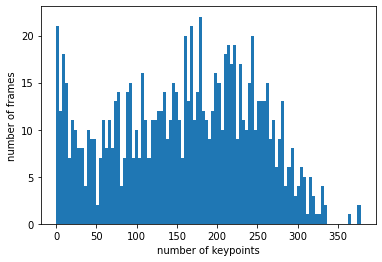

In [7]:
plt.xlabel('number of keypoints')
plt.ylabel('number of frames')
plt.hist(a, bins=100)

In [47]:
a = [1,2,3]
b =[5,6,7]
b.extend(a)

In [48]:
b

[5, 6, 7, 1, 2, 3]